In [ ]:
# FOR GOOGLE COLAB EXECUTION
# This version modifies the script to be run in Google Colab, removing argparse and enabling file upload directly.

# --- Required Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Colab specific
from google.colab import files
import io

# --- Upload Dataset ---
uploaded = files.upload()
file_name = next(iter(uploaded))
file_path = io.BytesIO(uploaded[file_name])

# --- Output Directory ---
output_dir = "/content/output"
os.makedirs(output_dir, exist_ok=True)

Saving finaldataset.xlsx to finaldataset.xlsx


In [ ]:
def load_data(file_path):
    """
    Load weather data from Excel file
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


In [ ]:
def preprocess_data(df):
    """
    Preprocess the data for modeling
    """
    # Standardize column names
    df.columns = [
        "Date", "Temp Max (F)", "Temp Avg (F)", "Temp Min (F)",
        "Dew Point Max (F)", "Dew Point Avg (F)", "Dew Point Min (F)",
        "Humidity Max (%)", "Humidity Avg (%)", "Humidity Min (%)",
        "Wind Speed Max (mph)", "Wind Speed Avg (mph)", "Wind Speed Min (mph)",
        "Pressure Max (in)", "Pressure Avg (in)", "Pressure Min (in)",
        "Precipitation Total (in)"
    ]

    # Display basic statistics
    print("Dataset Overview:")
    print(df.describe().T)

    # Check for missing values and handle them
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())

    # Convert Date to datetime first
    if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
        df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
        print("\nConverted Date column to datetime format")

    # Better handling of missing values using simple linear interpolation
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if column == "Date":
                continue
            # Use linear interpolation for all columns
            df[column] = df[column].interpolate(method='linear')

    # Extract temporal features that may help with agricultural predictions
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfYear"] = df["Date"].dt.dayofyear
    df["Season"] = df["Month"].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                  'Spring' if x in [3, 4, 5] else
                                  'Summer' if x in [6, 7, 8] else 'Fall')

    # Convert Season to numeric for modeling
    season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df["Season_Numeric"] = df["Season"].map(season_map)

    return df

In [ ]:
def prepare_features_targets(df):
    """
    Prepare features and targets for model training
    """
    # Define features and targets
    features = [
        "Dew Point Avg (F)", "Humidity Avg (%)", "Wind Speed Avg (mph)",
        "Pressure Avg (in)", "Precipitation Total (in)",
        "Month", "DayOfYear", "Season_Numeric"
    ]

    # Define primary targets for agricultural prediction
    target_temp = "Temp Avg (F)"
    target_humidity = "Humidity Avg (%)"

    # Prepare data for modeling
    X = df[features]
    y_temp = df[target_temp]
    y_humidity = df[target_humidity]

    # Check for remaining missing values and handle them
    X.fillna(X.mean(), inplace=True)
    y_temp.fillna(y_temp.mean(), inplace=True)
    y_humidity.fillna(y_humidity.mean(), inplace=True)

    print("\nMissing values after cleaning:")
    print(X.isnull().sum())

    return X, y_temp, y_humidity, features


In [ ]:
def calculate_precision_for_regression(y_true, y_pred, threshold=0.05):
    """
    Calculate precision for regression predictions by converting to binary classification
    based on how close predictions are to actual values.

    Args:
        y_true: Actual values
        y_pred: Predicted values
        threshold: Relative error threshold to consider a prediction as "correct" (default: 5%)

    Returns:
        float: Precision score
    """
    # Calculate relative error
    rel_error = np.abs(y_true - y_pred) / np.abs(y_true)

    # Create binary arrays (1 = prediction within threshold, 0 = prediction outside threshold)
    y_pred_binary = (rel_error <= threshold).astype(int)

    # For precision, we need "true" labels
    # Here we define "true" as "prediction is good enough" (within threshold)

    # Filter to only include cases where model predicted positive (within threshold)
    positives_mask = (y_pred_binary == 1)

    if not np.any(positives_mask):
        return 0.0  # No positive predictions

    # Calculate precision: true positives / (true positives + false positives)
    # Since all our "y_true_binary" values are 1, precision is simply the mean of y_pred_binary
    precision = np.mean(y_pred_binary[positives_mask])

    return precision

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name, model_name, output_dir=None):
    """
    Evaluate model performance and generate visualizations
    """
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate traditional regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate precision for regression
    precision_5pct = calculate_precision_for_regression(y_test, y_pred, threshold=0.05)  # 5% threshold
    precision_10pct = calculate_precision_for_regression(y_test, y_pred, threshold=0.10)  # 10% threshold

    # Print metrics
    print(f"{model_name} - {target_name} Prediction:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Precision (5% threshold): {precision_5pct:.4f}")
    print(f"  Precision (10% threshold): {precision_10pct:.4f}")

    # Create actual vs predicted plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

    # Add perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    # Add 5% error bounds
    plt.plot([min_val, max_val], [min_val*1.05, max_val*1.05], 'g--', linewidth=1, alpha=0.6)
    plt.plot([min_val, max_val], [min_val*0.95, max_val*0.95], 'g--', linewidth=1, alpha=0.6)

    plt.xlabel(f"Actual {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Actual vs Predicted {target_name} ({model_name})")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_scatter.png"))
    plt.show()

    # Create residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution for {target_name} ({model_name})")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_residuals.png"))
    plt.show()

    # Create precision visualization - show percent of predictions within thresholds
    rel_errors = np.abs(y_test - y_pred) / np.abs(y_test)
    thresholds = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]
    precisions = [np.mean(rel_errors <= t) for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.bar([f"{t*100}%" for t in thresholds], precisions, color='skyblue')
    plt.axhline(y=0.8, color='r', linestyle='--', label="80% target")
    plt.ylim(0, 1)
    for i, v in enumerate(precisions):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
    plt.xlabel("Error Threshold")
    plt.ylabel("Precision (% of predictions within threshold)")
    plt.title(f"Prediction Precision at Different Thresholds - {target_name} ({model_name})")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_precision.png"))
    plt.show()

    return (mae, mse, rmse, r2, precision_5pct, precision_10pct)


In [ ]:
def plot_model_precision_comparison(results_dict, target, output_dir=None):
    """
    Plot comparison of model precision
    """
    model_names = list(results_dict.keys())
    precision_5pct = [results_dict[name][4] for name in model_names]
    r2_scores = [results_dict[name][3] for name in model_names]

    # Sort by precision
    sorted_indices = np.argsort(precision_5pct)
    sorted_models = [model_names[i] for i in sorted_indices]
    sorted_precision = [precision_5pct[i] for i in sorted_indices]
    sorted_r2 = [r2_scores[i] for i in sorted_indices]

    plt.figure(figsize=(12, 8))

    # Create bar plot for precisions
    x = range(len(sorted_models))
    plt.barh(x, sorted_precision, height=0.4, color='skyblue', label='Precision (5% threshold)')

    # Add R² values
    for i, (r2, precision) in enumerate(zip(sorted_r2, sorted_precision)):
        plt.text(precision + 0.01, i, f"R² = {r2:.3f}", va='center')

    plt.yticks(x, sorted_models)
    plt.xlabel('Precision (% of predictions within 5% threshold)')
    plt.ylabel('Model')
    plt.title(f"Model Precision Comparison for {target} Prediction")
    plt.xlim(0, 1)
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target.lower()}_model_comparison.png"))
    plt.show()

def combined_score(estimator, X, y):
    """
    Custom scorer that combines R² and precision
    """
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    precision = calculate_precision_for_regression(y, y_pred, threshold=0.05)
    return (r2 + precision) / 2


In [ ]:
def tune_model(model_name, model, X_train, y_train, target):
    """
    Perform hyperparameter tuning using GridSearchCV
    """
    if model_name in ["Random Forest", "Gradient Boosting", "Extra Trees"]:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_name == "AdaBoost":
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0]
        }
    elif model_name in ["Ridge Regression", "Lasso Regression"]:
        param_grid = {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    elif model_name == "Support Vector Machine":
        param_grid = {
            'C': [1, 10, 100],
            'gamma': [0.01, 0.1, 1],
            'epsilon': [0.01, 0.1, 0.5]
        }
    elif model_name == "K-Nearest Neighbors":
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    elif model_name == "Decision Tree":
        param_grid = {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
        print(f"No hyperparameter tuning defined for {model_name}")
        return None

    # Define cross-validation strategy
    cv_strategy = 5  # 5-fold cross-validation

    # Create grid search with custom scorer
    grid_search = GridSearchCV(
        model, param_grid, cv=cv_strategy,
        scoring=combined_score, n_jobs=-1, verbose=1
    )

    # Fit grid search
    print(f"\nTuning {model_name} for {target} prediction...")
    grid_search.fit(X_train, y_train)

    # Print results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Combined Score: {grid_search.best_score_:.4f}")

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_train)
    r2 = r2_score(y_train, y_pred)
    precision = calculate_precision_for_regression(y_train, y_pred, threshold=0.05)

    print(f"Training R²: {r2:.4f}")
    print(f"Training Precision (5% threshold): {precision:.4f}")

    return grid_search.best_estimator_


In [ ]:
def predict_future_weather(input_data, temp_model, humidity_model):
    """
    Predict future weather based on input features

    Args:
        input_data (pd.DataFrame): Dataframe with required features
        temp_model: Trained temperature prediction model
        humidity_model: Trained humidity prediction model

    Returns:
        pd.DataFrame: Dataframe with predicted temperature and humidity
    """
    # Make predictions
    predicted_temp = temp_model.predict(input_data)
    predicted_humidity = humidity_model.predict(input_data)

    # Create results dataframe
    results = pd.DataFrame({
        'Date': input_data.index if hasattr(input_data, 'index') else range(len(predicted_temp)),
        'Predicted_Temperature': predicted_temp,
        'Predicted_Humidity': predicted_humidity
    })

    # Add confidence information based on historical precision
    results['Temp_Range_Low'] = predicted_temp * 0.95  # 5% margin
    results['Temp_Range_High'] = predicted_temp * 1.05
    results['Humidity_Range_Low'] = predicted_humidity * 0.95
    results['Humidity_Range_High'] = predicted_humidity * 1.05

    return results



In [ ]:
def predict_for_specific_day(day_of_year, month, dew_point, humidity, wind_speed, pressure, precipitation, temp_model, humidity_model):
    """
    Make a prediction for a specific day with precision estimates
    """
    # Determine season from month
    season = 0 if month in [12, 1, 2] else 1 if month in [3, 4, 5] else 2 if month in [6, 7, 8] else 3

    # Create input dataframe
    input_data = pd.DataFrame({
        "Dew Point Avg (F)": [dew_point],
        "Humidity Avg (%)": [humidity],
        "Wind Speed Avg (mph)": [wind_speed],
        "Pressure Avg (in)": [pressure],
        "Precipitation Total (in)": [precipitation],
        "Month": [month],
        "DayOfYear": [day_of_year],
        "Season_Numeric": [season]
    })

    # Make predictions
    temp_prediction = temp_model.predict(input_data)[0]
    humidity_prediction = humidity_model.predict(input_data)[0]

    print(f"\nPrediction for day {day_of_year} (Month {month}):")
    print(f"Predicted Temperature: {temp_prediction:.2f} °F (Precision range: {temp_prediction*0.95:.2f}-{temp_prediction*1.05:.2f} °F)")
    print(f"Predicted Humidity: {humidity_prediction:.2f} % (Precision range: {humidity_prediction*0.95:.2f}-{humidity_prediction*1.05:.2f} %)")

    # Return predictions in a structured format
    return {
        'temperature': {
            'prediction': temp_prediction,
            'range_low': temp_prediction * 0.95,
            'range_high': temp_prediction * 1.05
        },
        'humidity': {
            'prediction': humidity_prediction,
            'range_low': humidity_prediction * 0.95,
            'range_high': humidity_prediction * 1.05
        }
    }

def plot_feature_importance(model, features, target, model_name, output_dir=None):
    """
    Plot feature importance for a model
    """
    if hasattr(model, 'feature_importances_'):
        feat_importances = pd.Series(model.feature_importances_, index=features)
        plt.figure(figsize=(10, 6))
        feat_importances.sort_values(ascending=False).plot(kind='barh')
        plt.xlabel("Feature Importance Score")
        plt.ylabel("Features")
        plt.title(f"Feature Importance for {target} Prediction ({model_name})")
        plt.tight_layout()

        if output_dir:
            plt.savefig(os.path.join(output_dir, f"{target.lower()}_{model_name.lower().replace(' ', '_')}_feature_importance.png"))
        plt.show()


Successfully loaded dataset with 1155 rows and 17 columns
Dataset Overview:
                           count                 mean                  min  \
Date                        1155  2023-08-01 00:00:00  2022-01-01 00:00:00   
Temp Max (F)              1152.0            92.974826                 63.0   
Temp Avg (F)              1152.0            81.664236                 62.6   
Temp Min (F)              1152.0            72.563368                 50.0   
Dew Point Max (F)         1152.0            67.644965                 46.0   
Dew Point Avg (F)         1152.0            64.215451                 40.3   
Dew Point Min (F)         1152.0            60.448785                 28.0   
Humidity Max (%)          1152.0            76.888021                  3.0   
Humidity Avg (%)          1152.0            60.699045                 18.5   
Humidity Min (%)          1152.0            41.461806                  7.0   
Wind Speed Max (mph)      1152.0             2.609375             

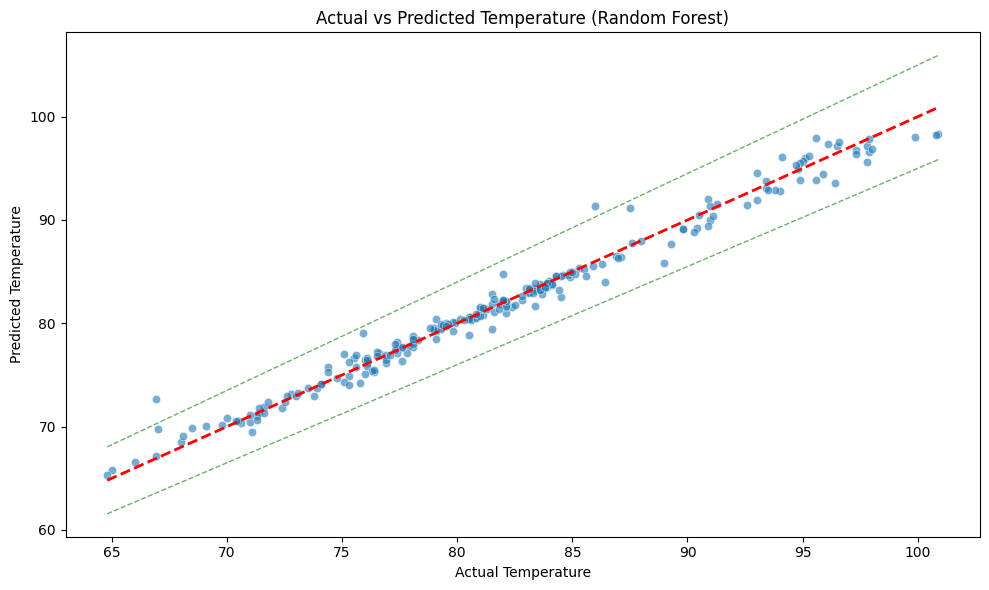

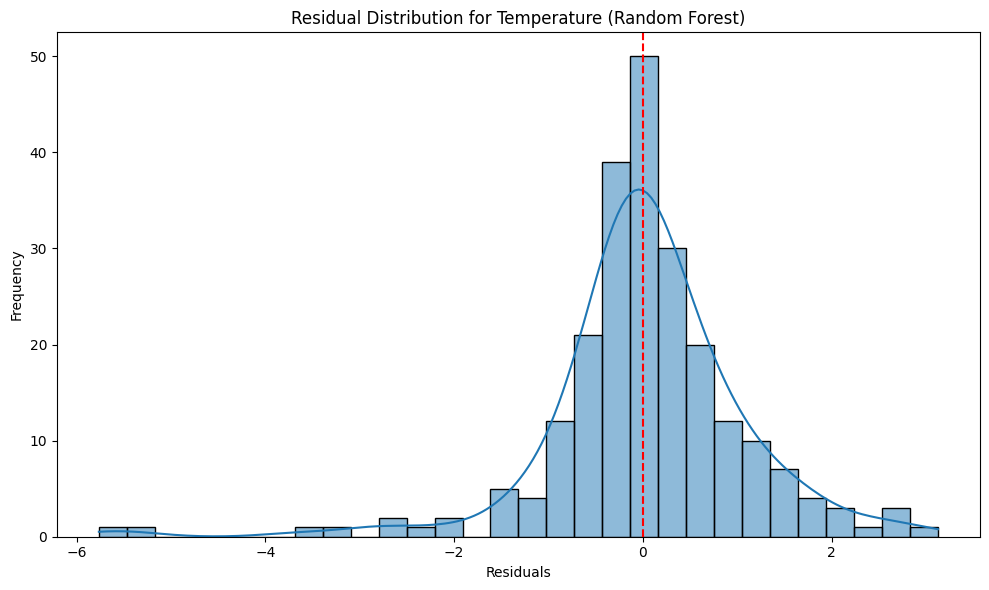

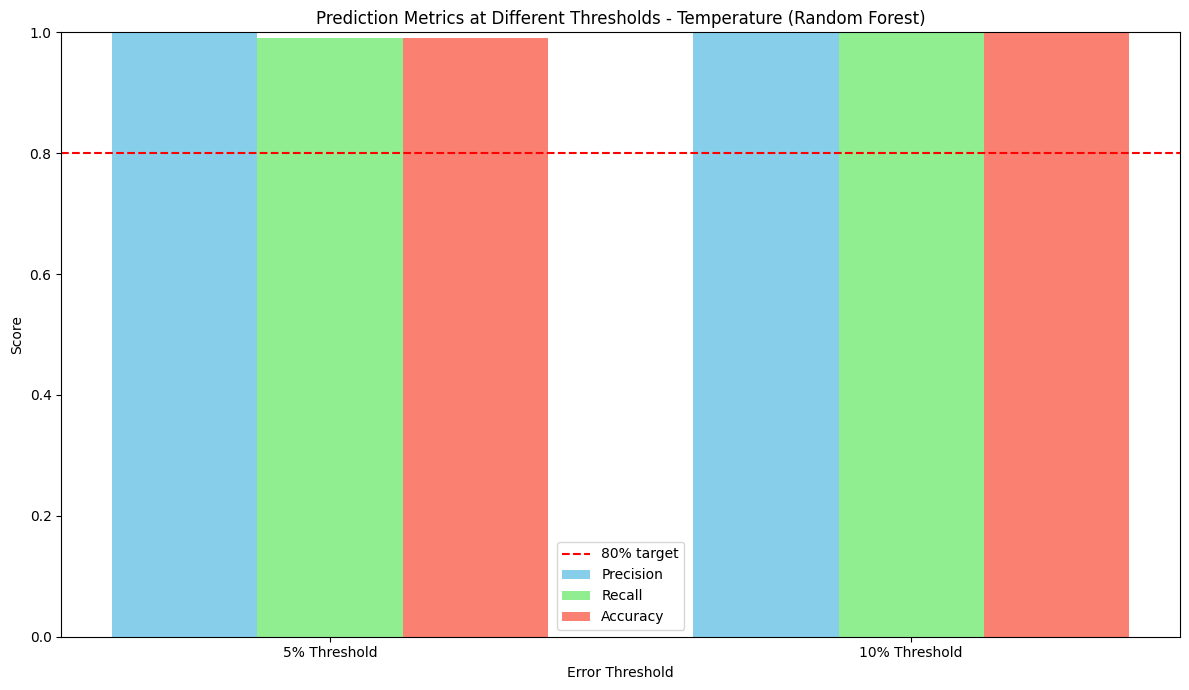

Gradient Boosting - Temperature Prediction:
  MAE: 0.72
  MSE: 1.00
  RMSE: 1.00
  R² Score: 0.9839
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9957
  Accuracy (5% threshold): 99.57%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


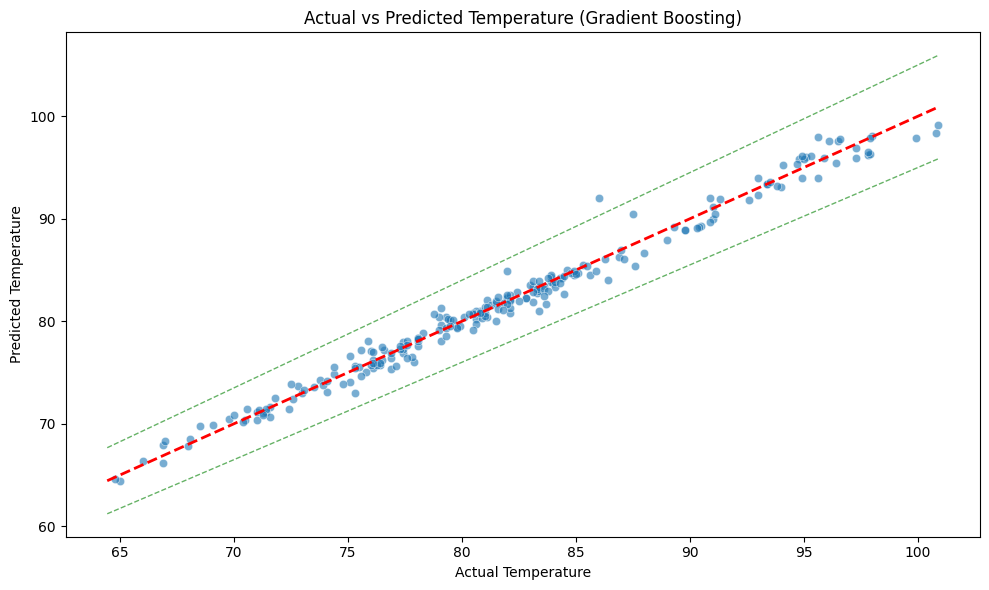

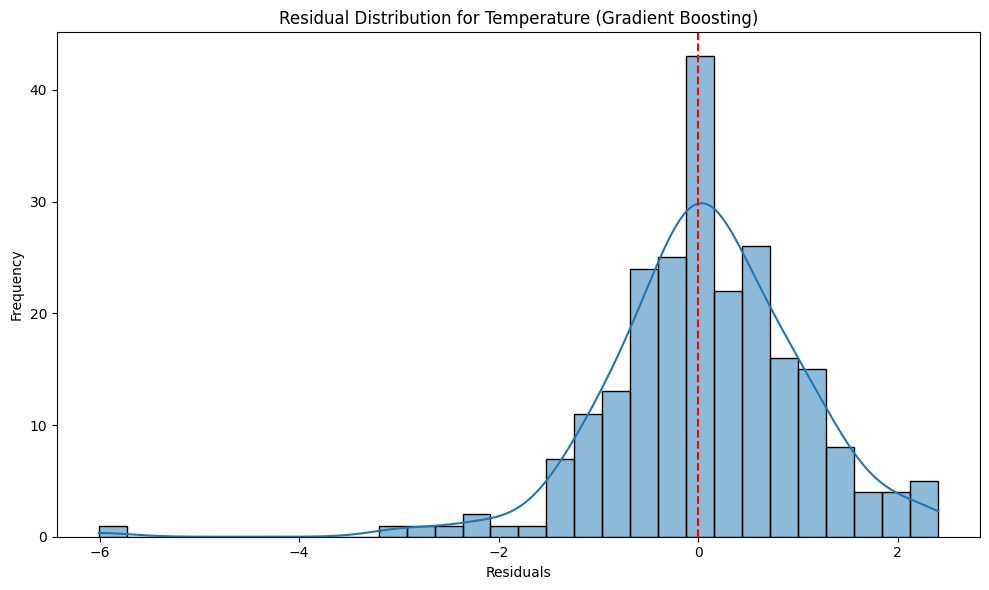

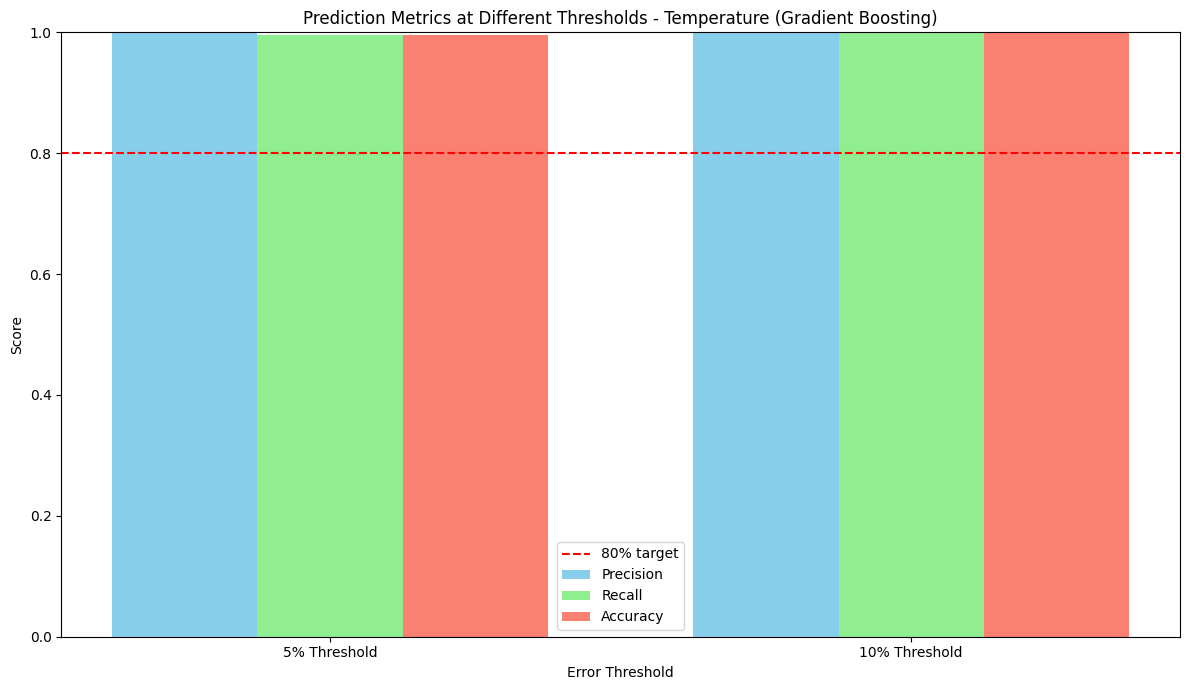

AdaBoost - Temperature Prediction:
  MAE: 2.09
  MSE: 6.94
  RMSE: 2.63
  R² Score: 0.8880
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.8874
  Accuracy (5% threshold): 88.74%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.9957
  Accuracy (10% threshold): 99.57%


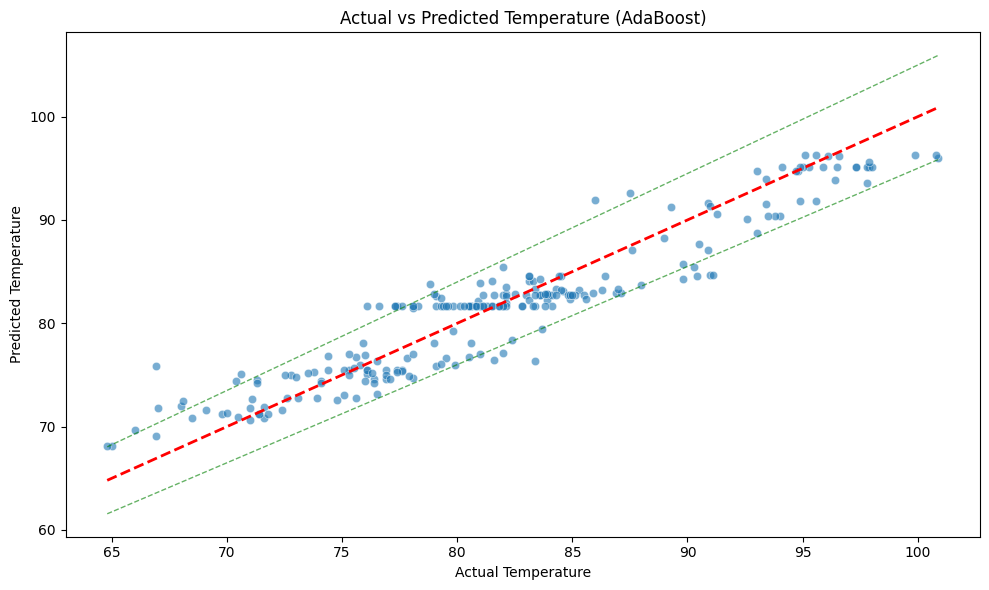

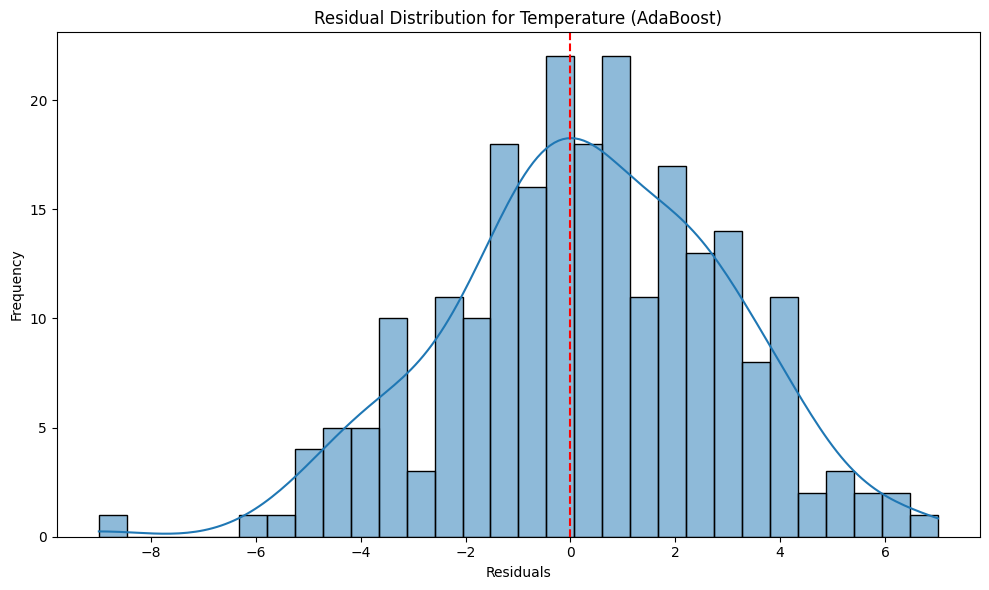

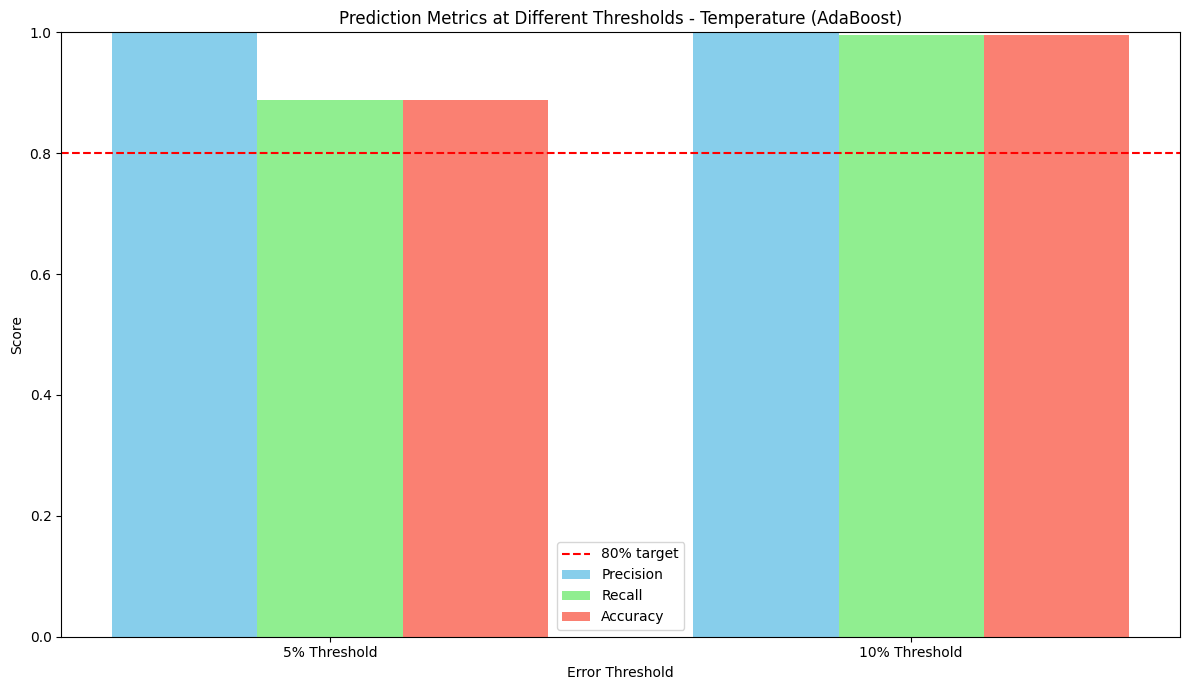

Extra Trees - Temperature Prediction:
  MAE: 0.66
  MSE: 0.90
  RMSE: 0.95
  R² Score: 0.9855
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9957
  Accuracy (5% threshold): 99.57%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


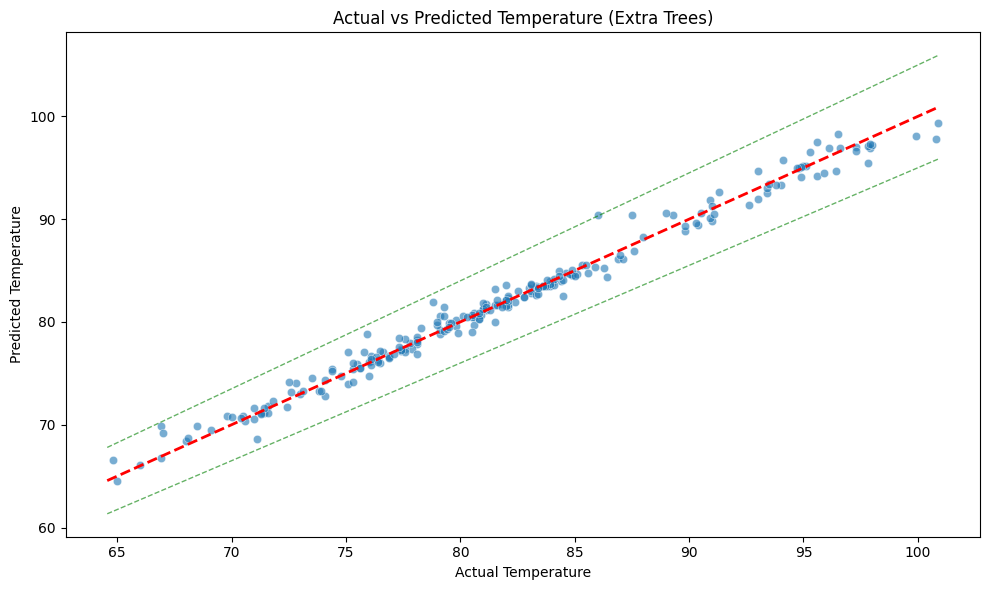

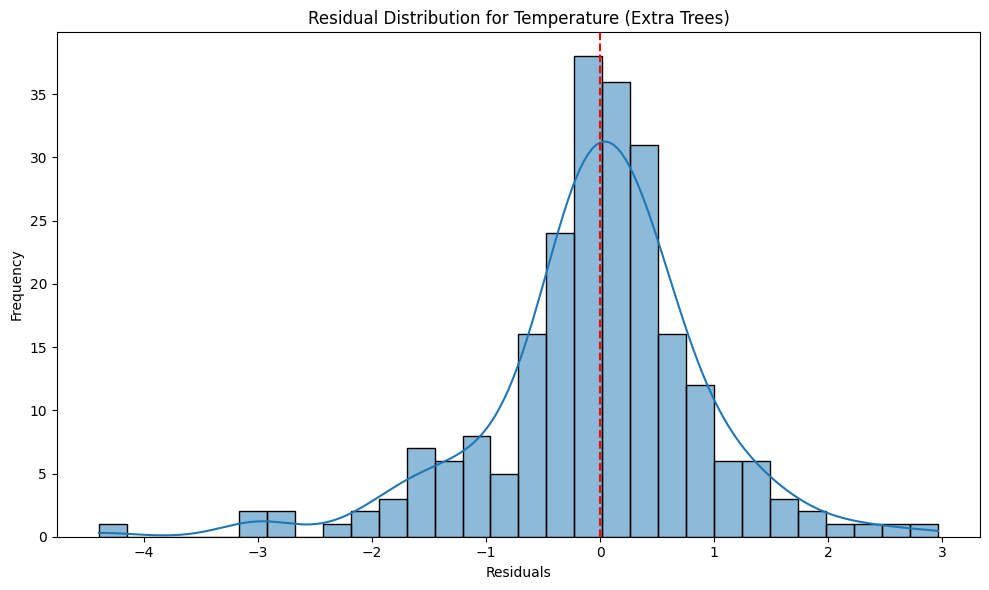

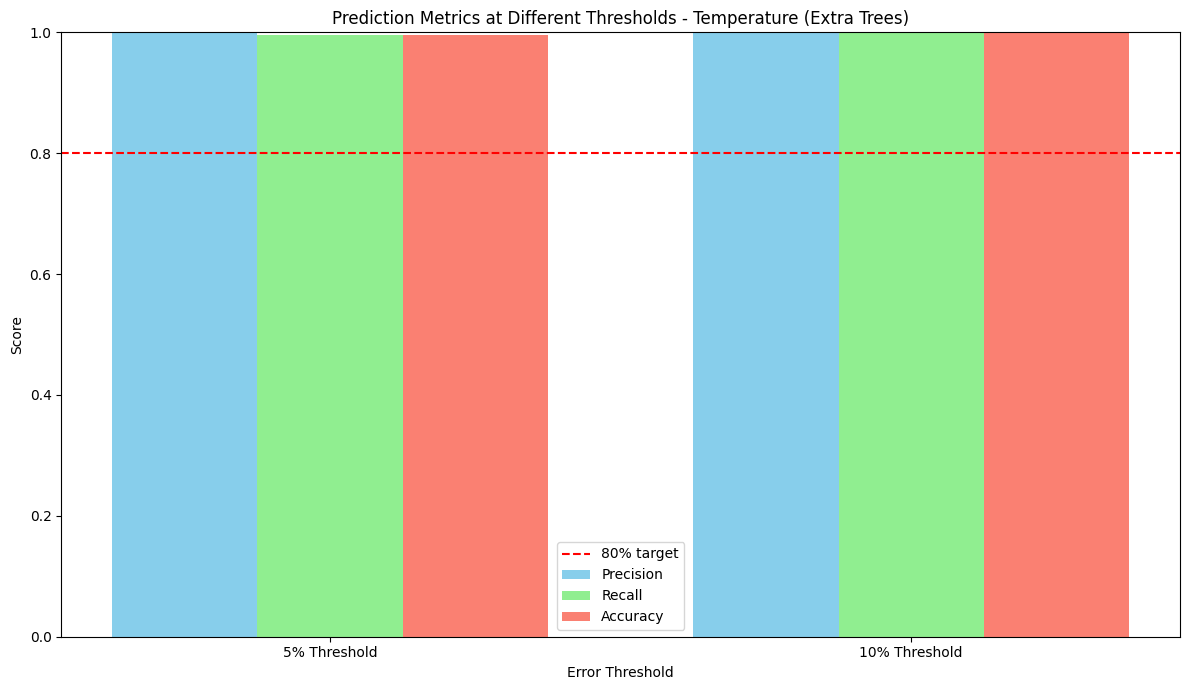

Linear Regression - Temperature Prediction:
  MAE: 1.27
  MSE: 2.85
  RMSE: 1.69
  R² Score: 0.9541
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9784
  Accuracy (5% threshold): 97.84%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


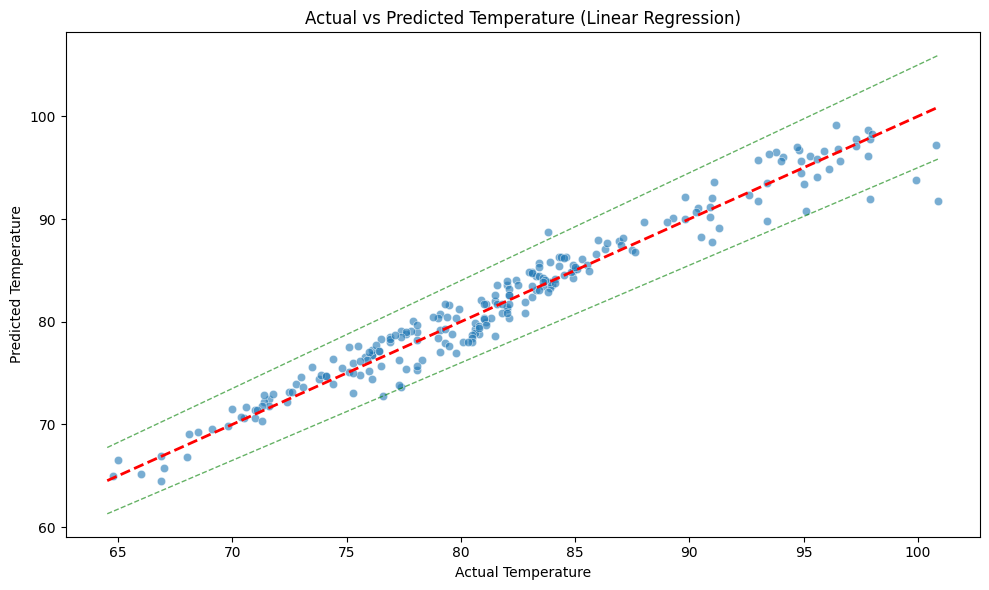

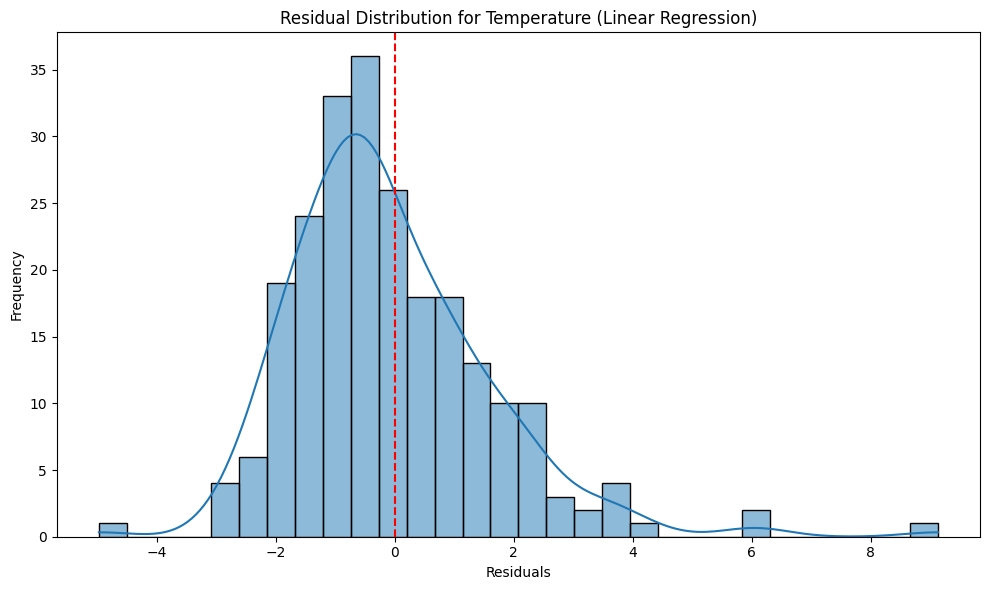

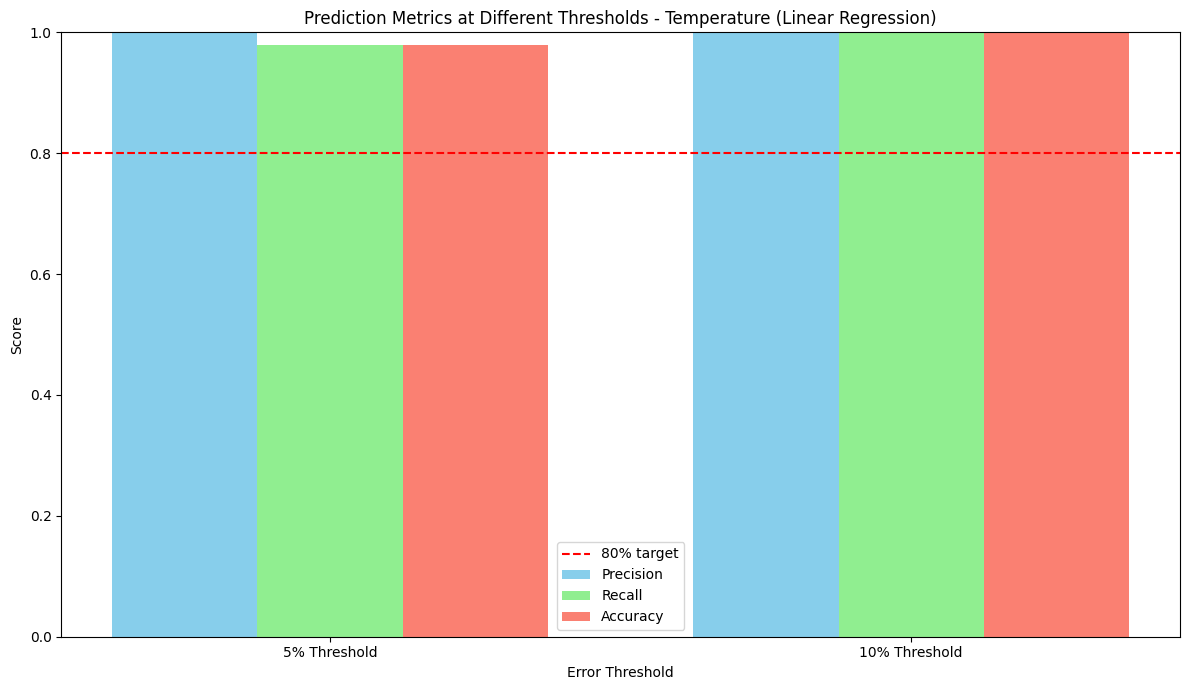

Ridge Regression - Temperature Prediction:
  MAE: 1.27
  MSE: 2.85
  RMSE: 1.69
  R² Score: 0.9541
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9784
  Accuracy (5% threshold): 97.84%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


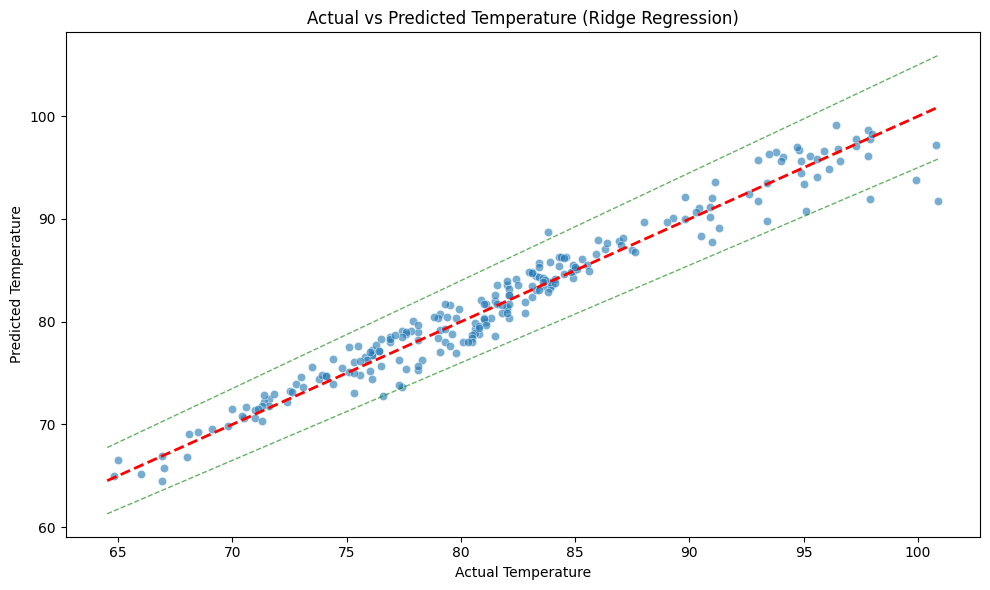

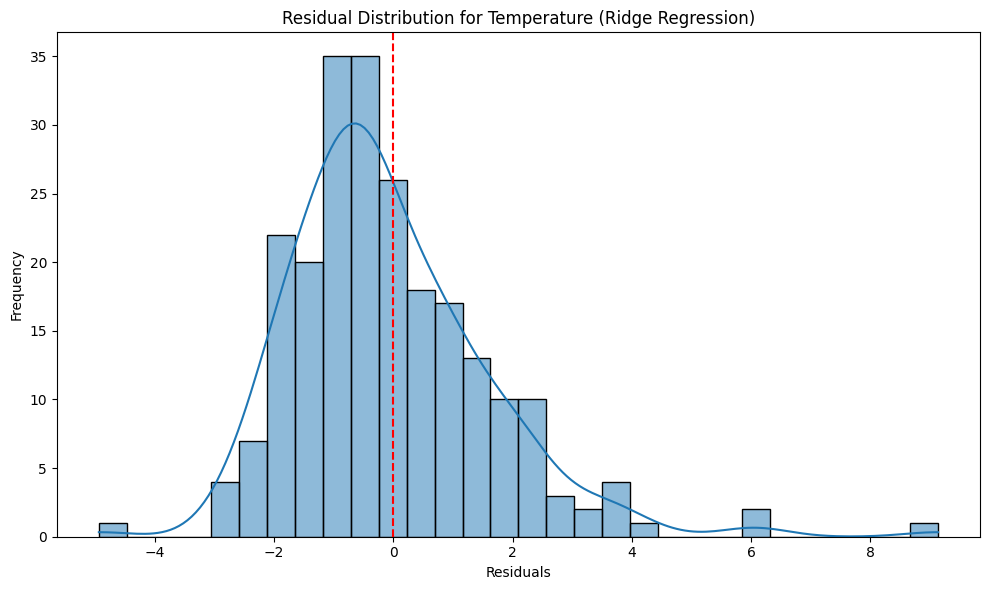

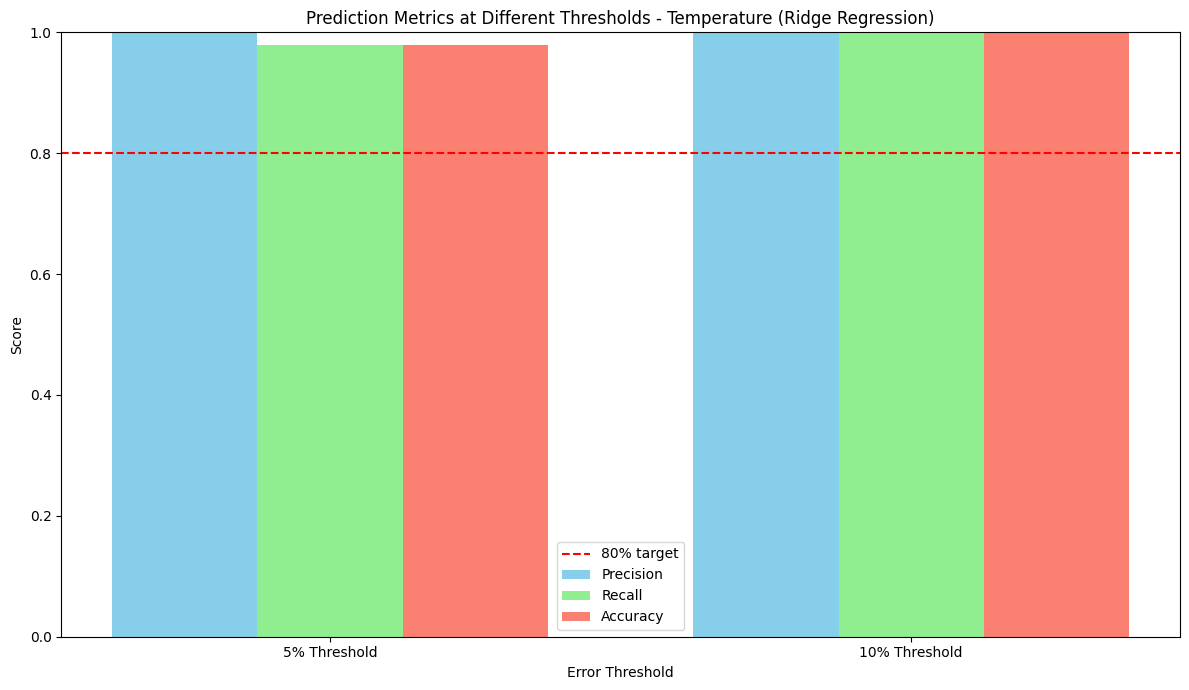

Lasso Regression - Temperature Prediction:
  MAE: 1.28
  MSE: 2.87
  RMSE: 1.70
  R² Score: 0.9536
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9784
  Accuracy (5% threshold): 97.84%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


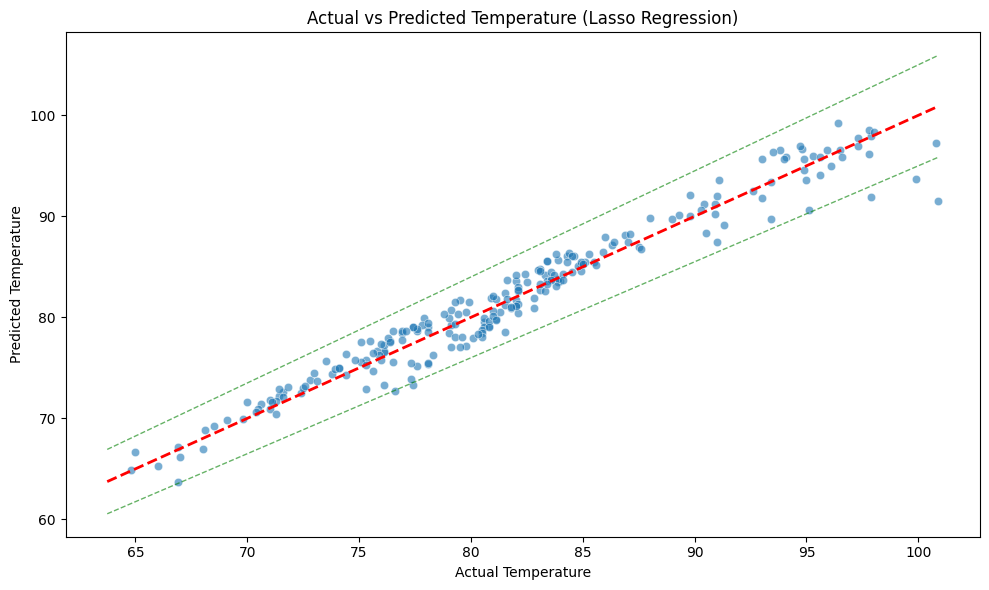

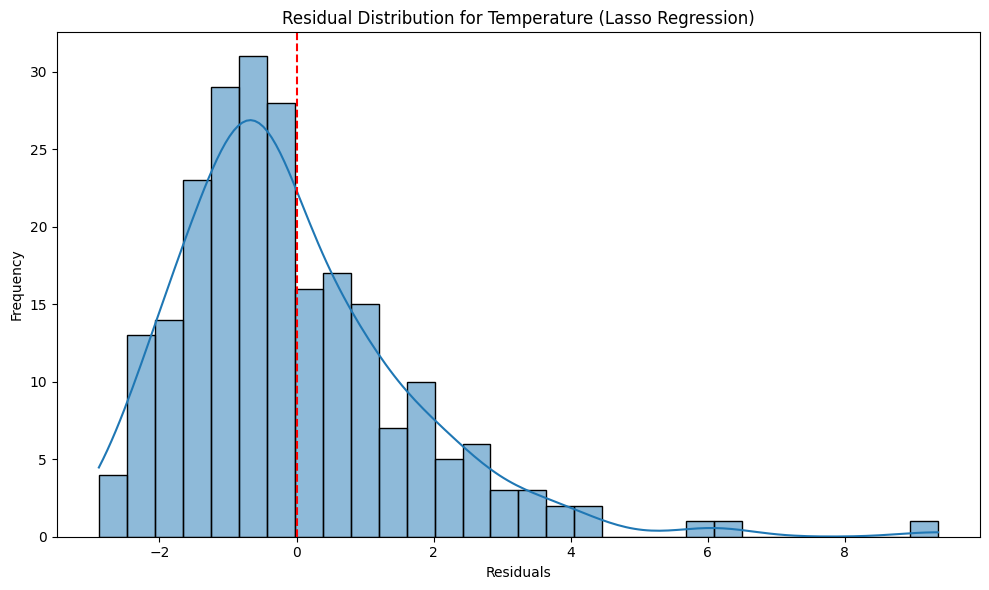

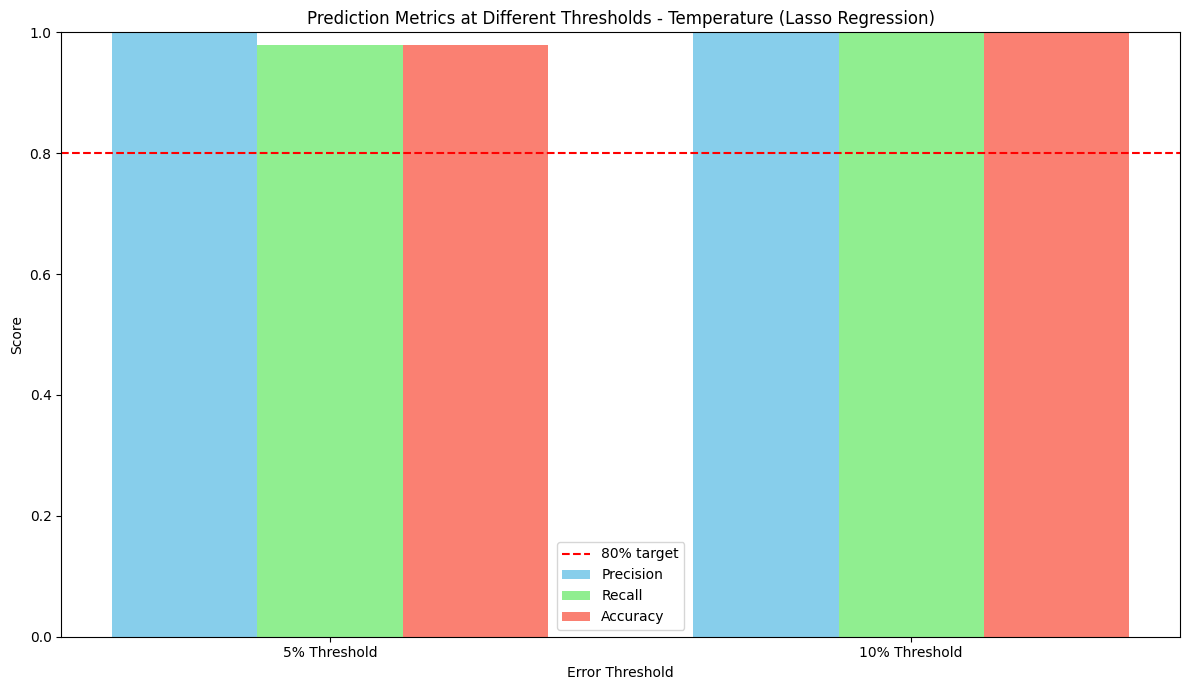

Support Vector Machine - Temperature Prediction:
  MAE: 2.37
  MSE: 14.52
  RMSE: 3.81
  R² Score: 0.7657
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.8182
  Accuracy (5% threshold): 81.82%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.9394
  Accuracy (10% threshold): 93.94%


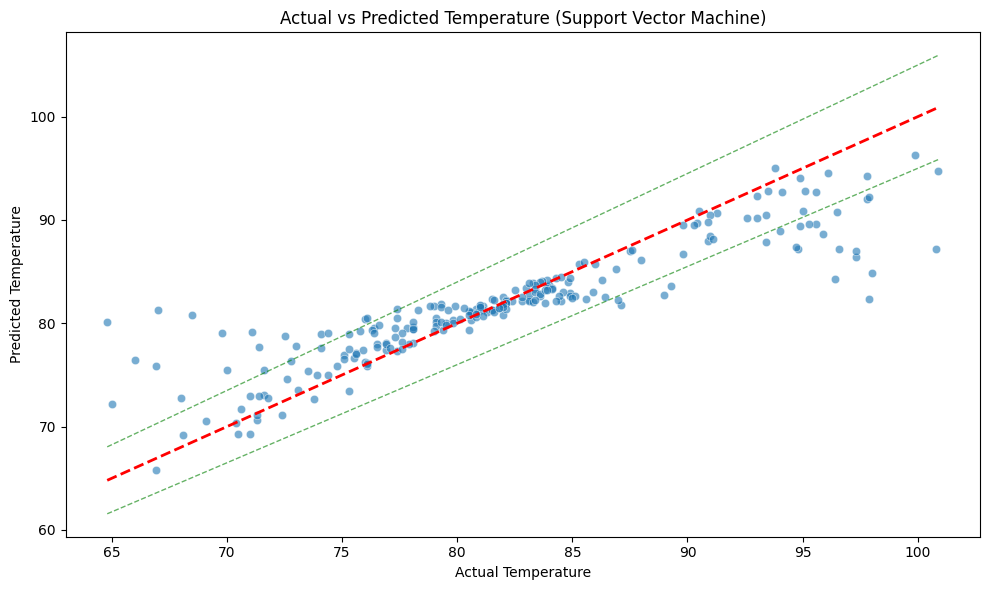

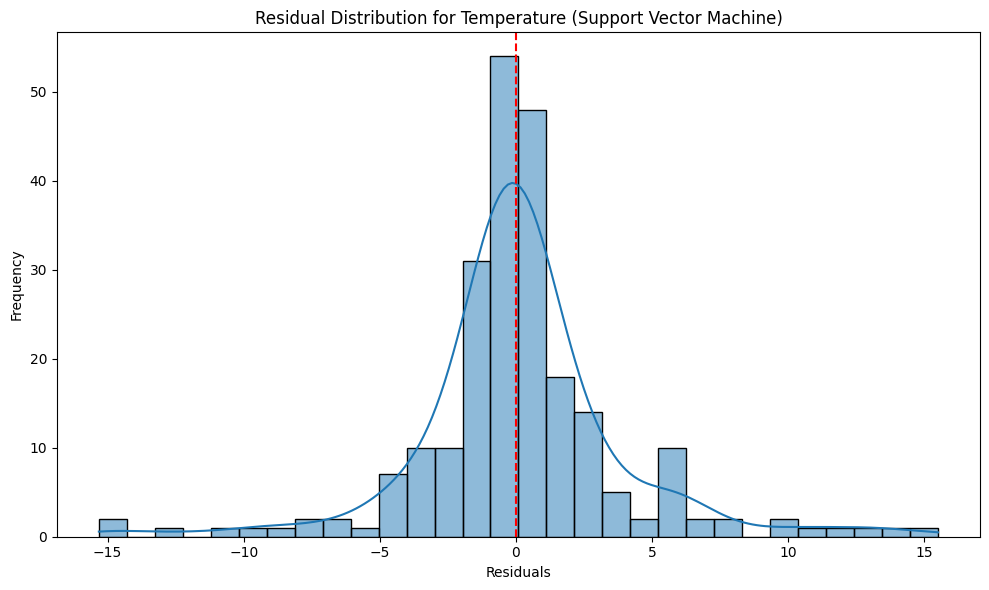

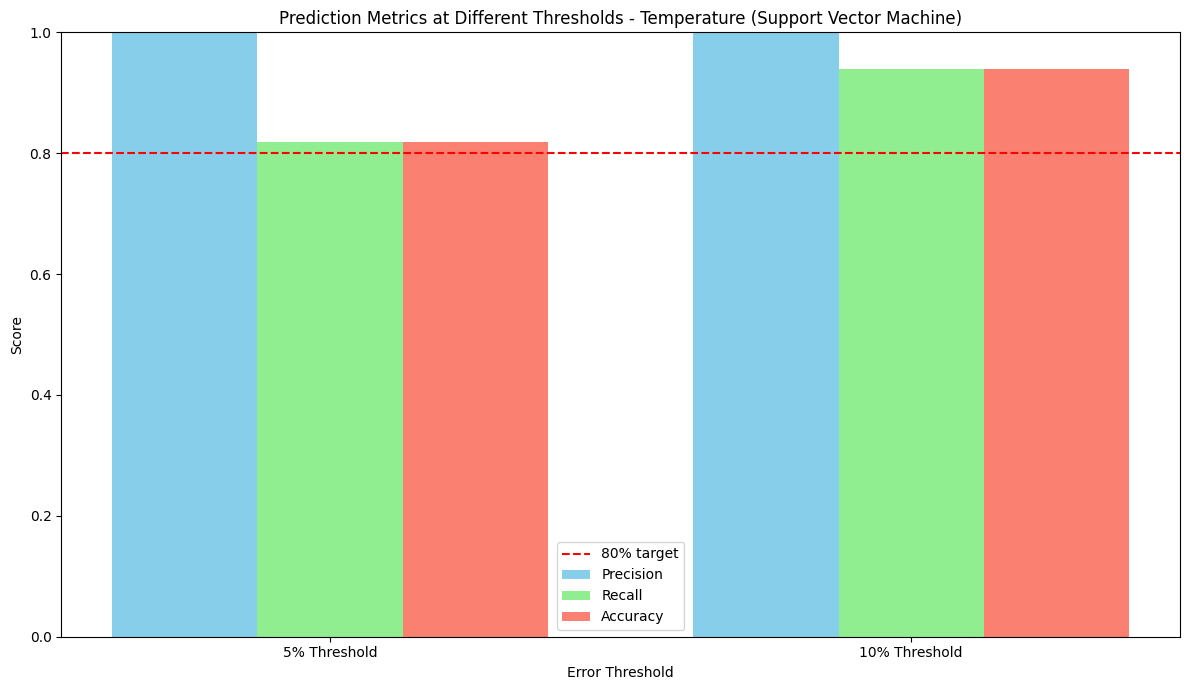

K-Nearest Neighbors - Temperature Prediction:
  MAE: 1.14
  MSE: 2.32
  RMSE: 1.52
  R² Score: 0.9625
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9784
  Accuracy (5% threshold): 97.84%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


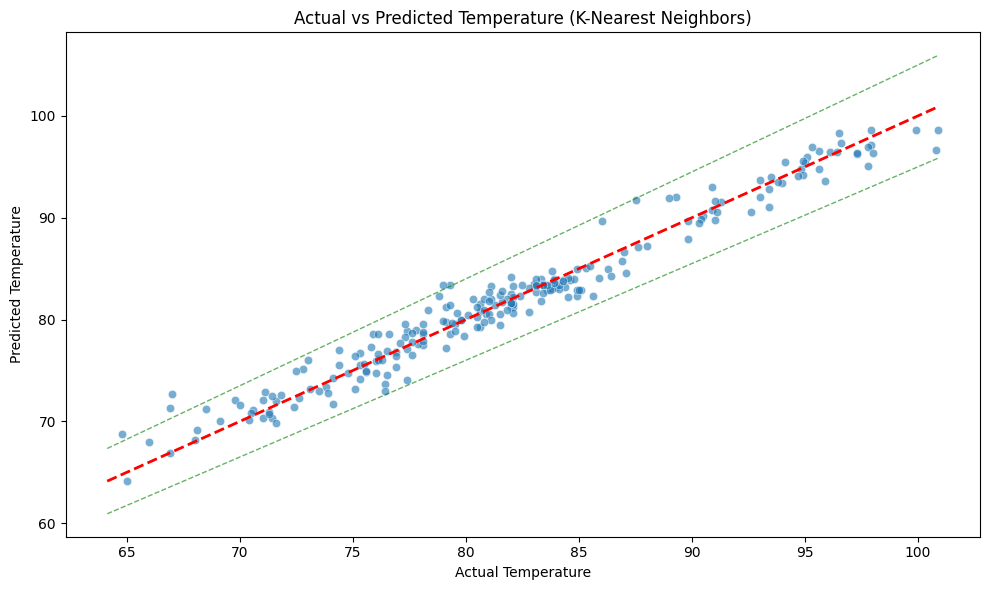

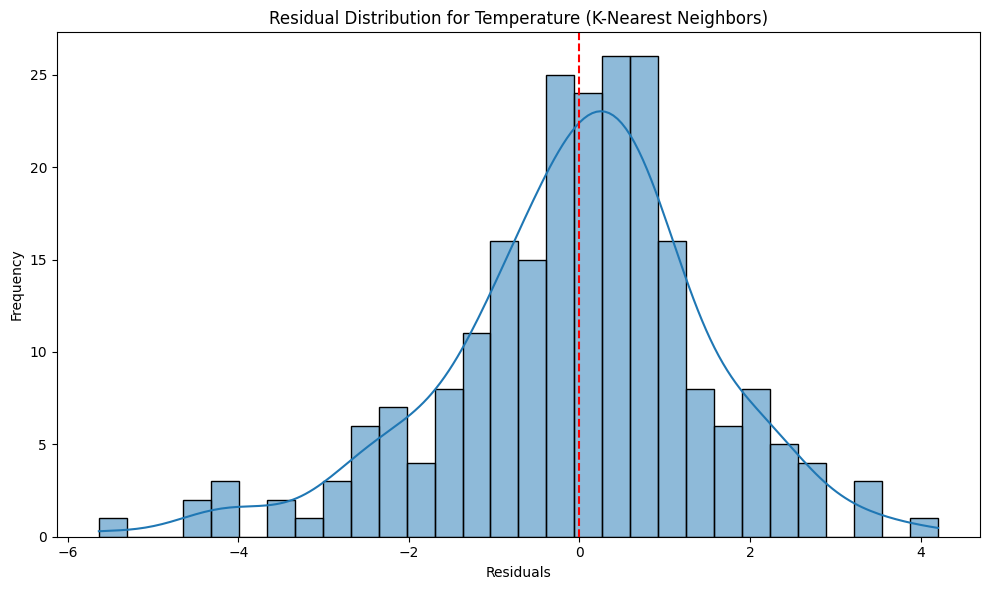

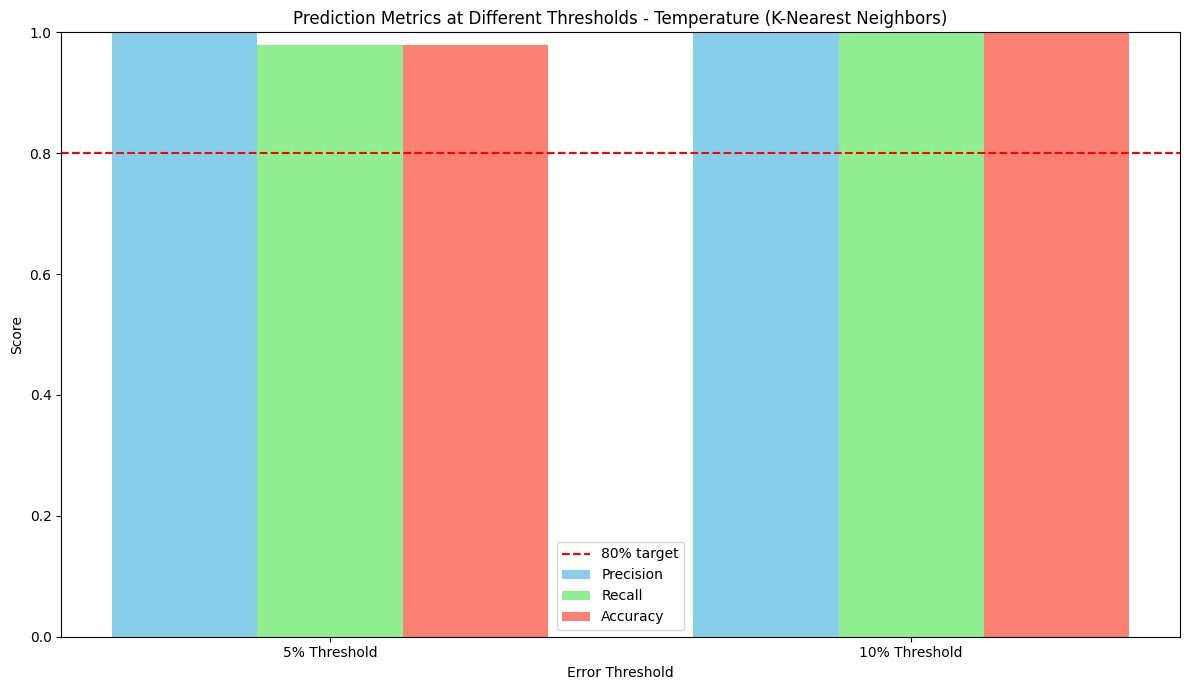

Decision Tree - Temperature Prediction:
  MAE: 1.01
  MSE: 2.15
  RMSE: 1.47
  R² Score: 0.9653
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9870
  Accuracy (5% threshold): 98.70%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.9957
  Accuracy (10% threshold): 99.57%


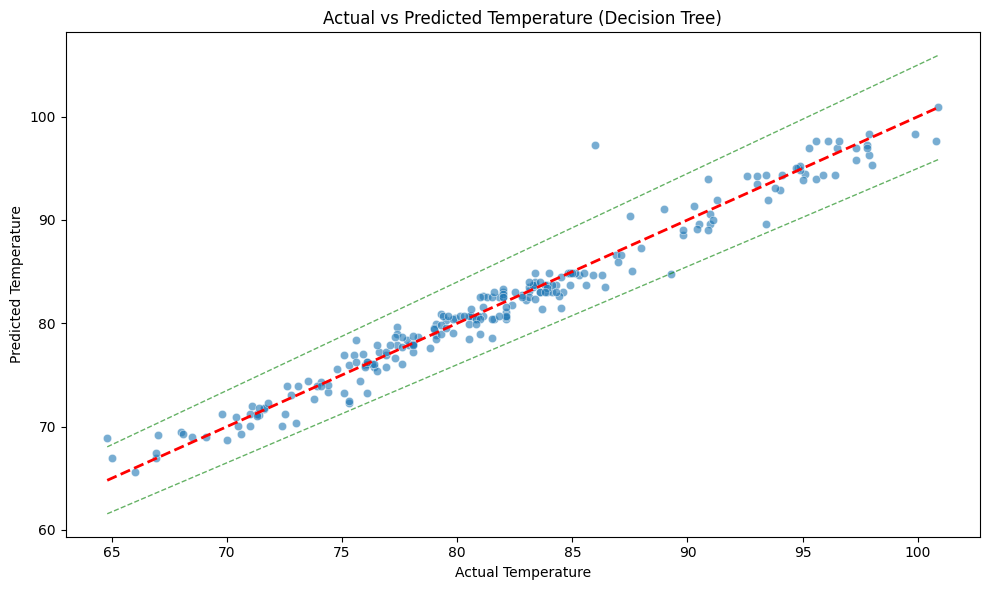

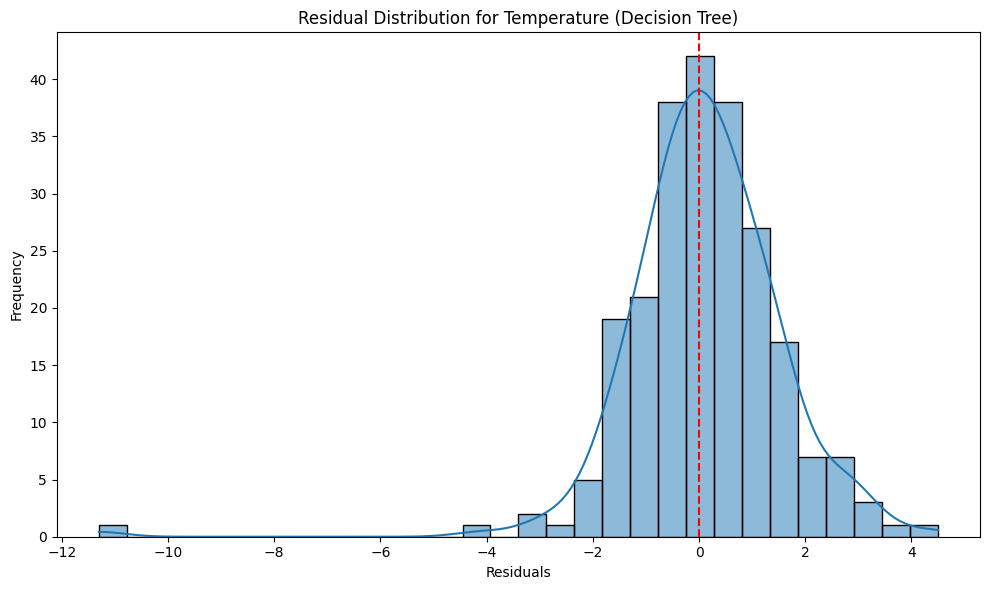

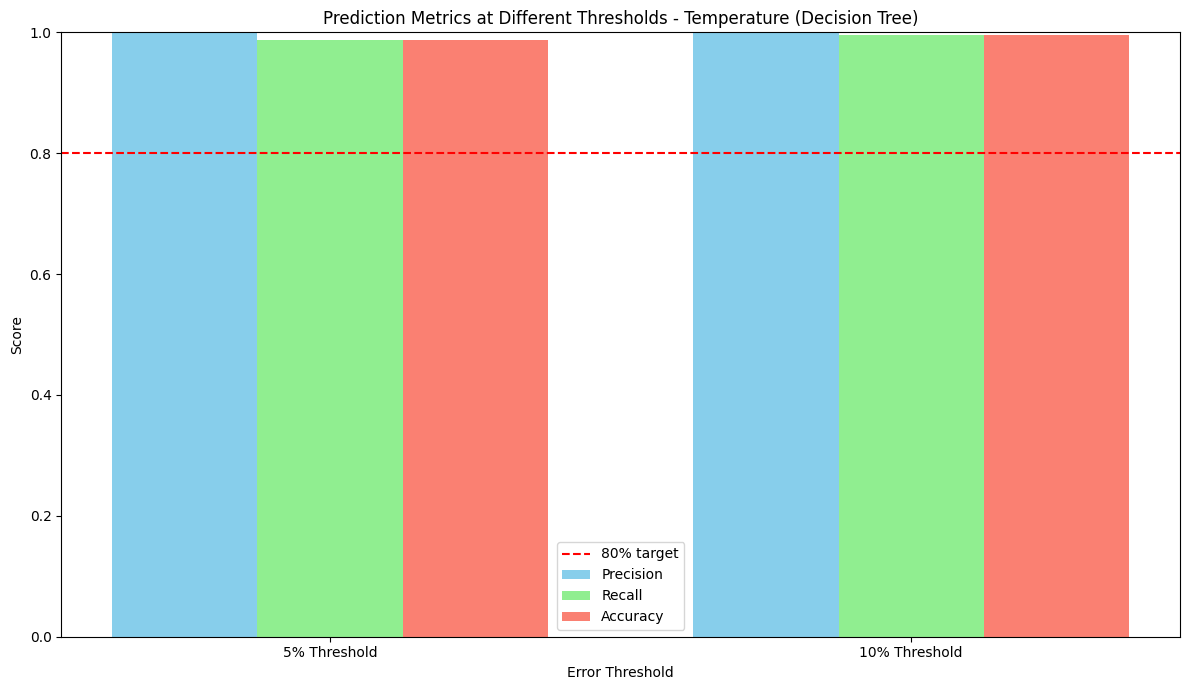


Evaluating Models for Humidity Prediction
Random Forest - Humidity Prediction:
  MAE: 0.06
  MSE: 0.01
  RMSE: 0.10
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


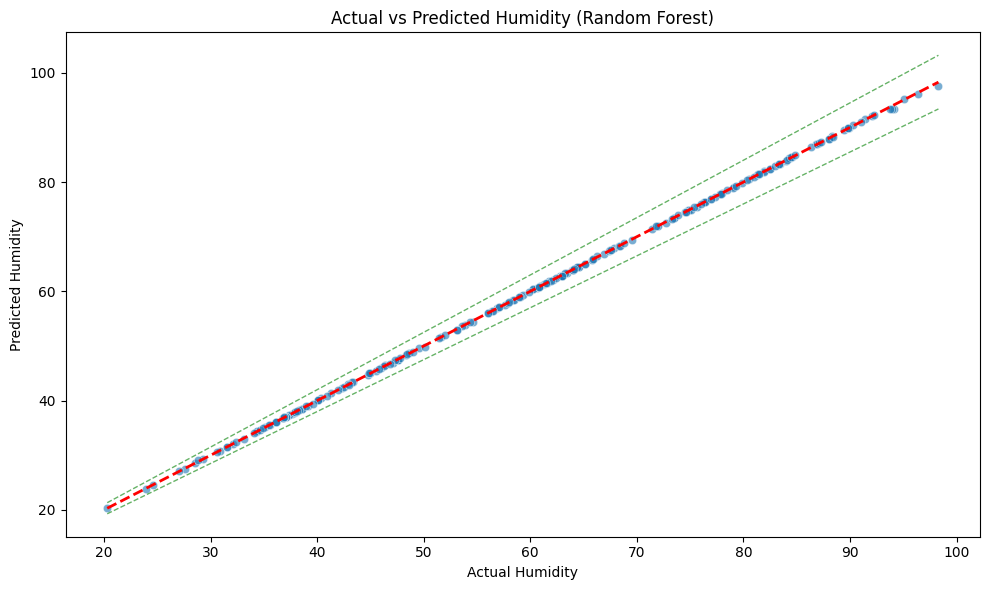

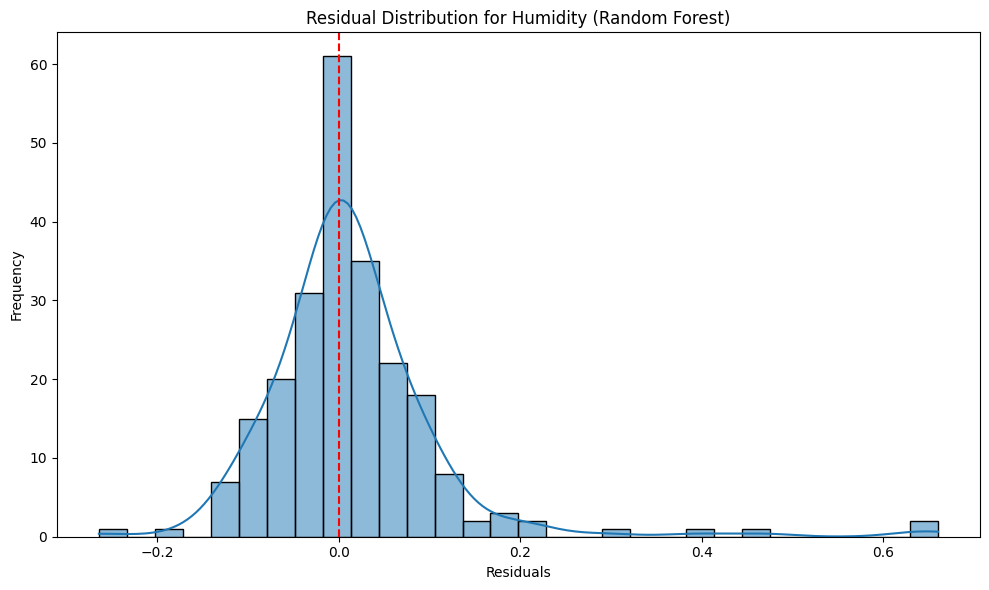

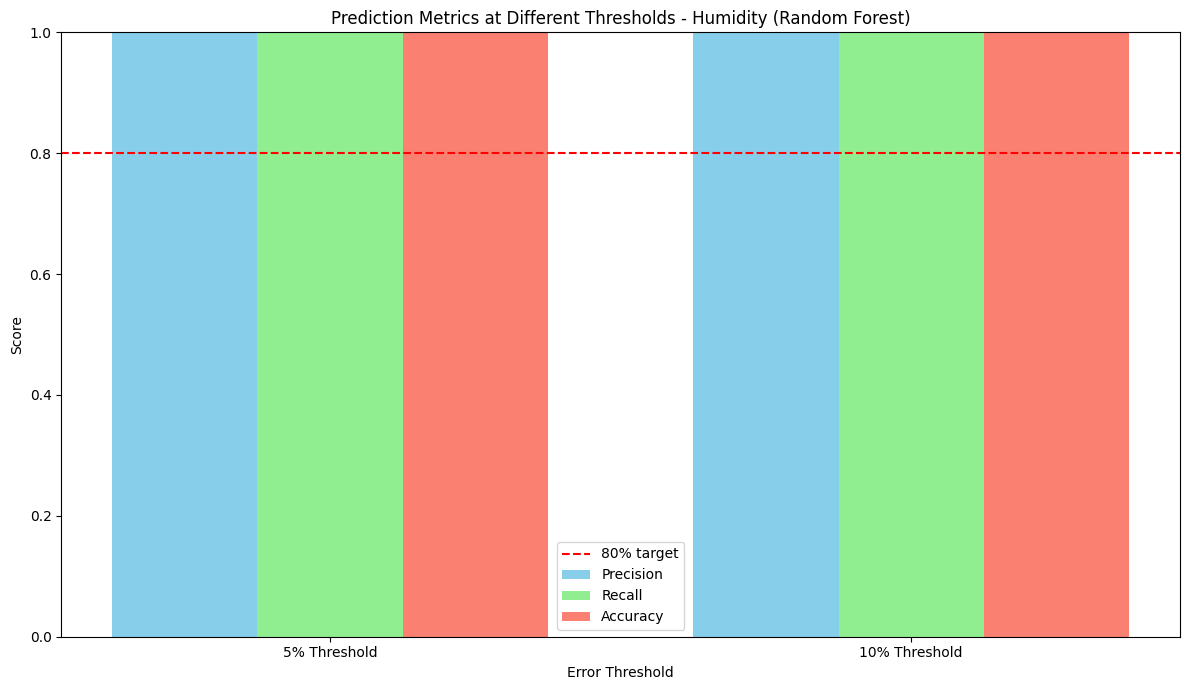

Gradient Boosting - Humidity Prediction:
  MAE: 0.11
  MSE: 0.02
  RMSE: 0.15
  R² Score: 0.9999
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


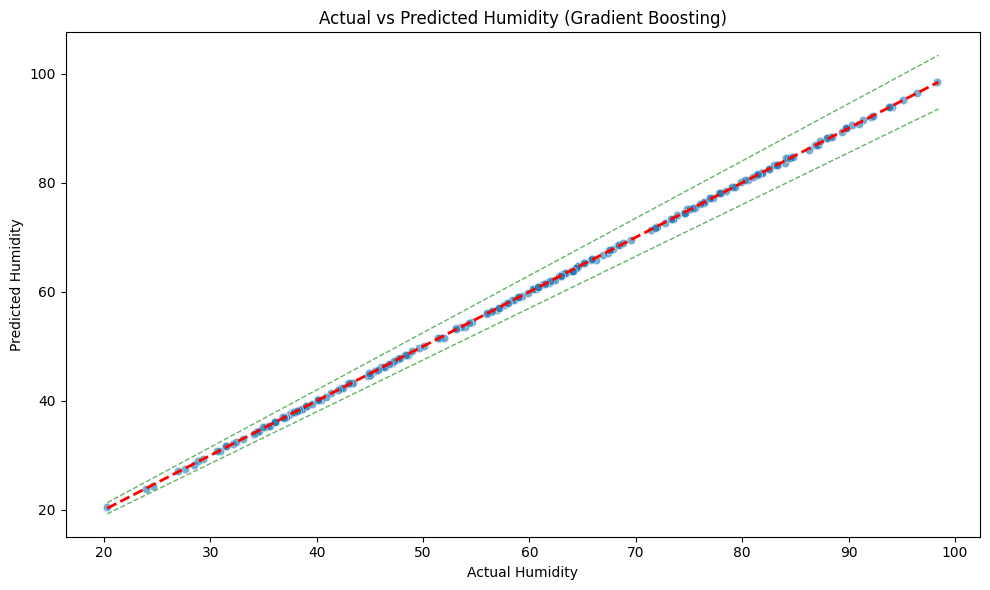

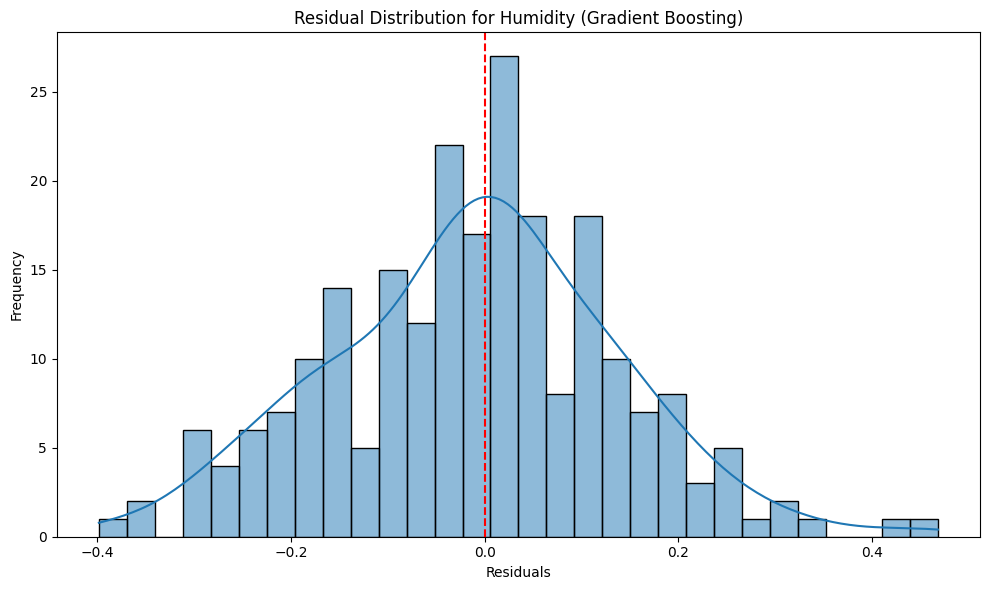

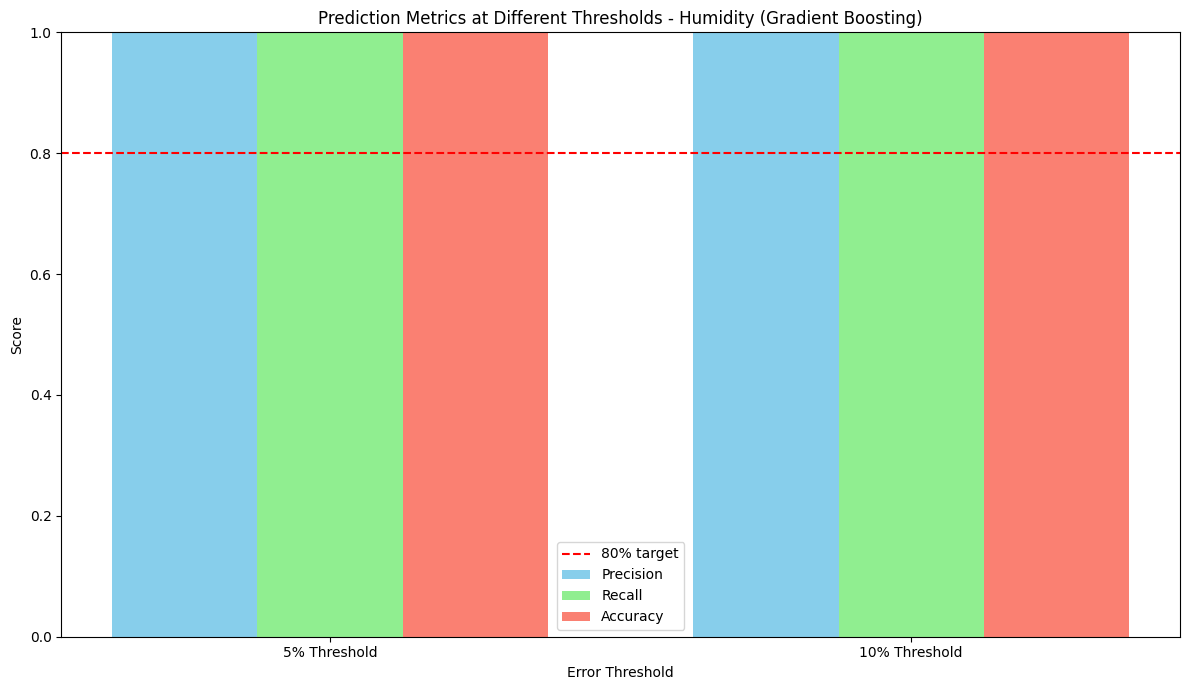

AdaBoost - Humidity Prediction:
  MAE: 1.11
  MSE: 1.78
  RMSE: 1.33
  R² Score: 0.9950
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9740
  Accuracy (5% threshold): 97.40%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.9957
  Accuracy (10% threshold): 99.57%


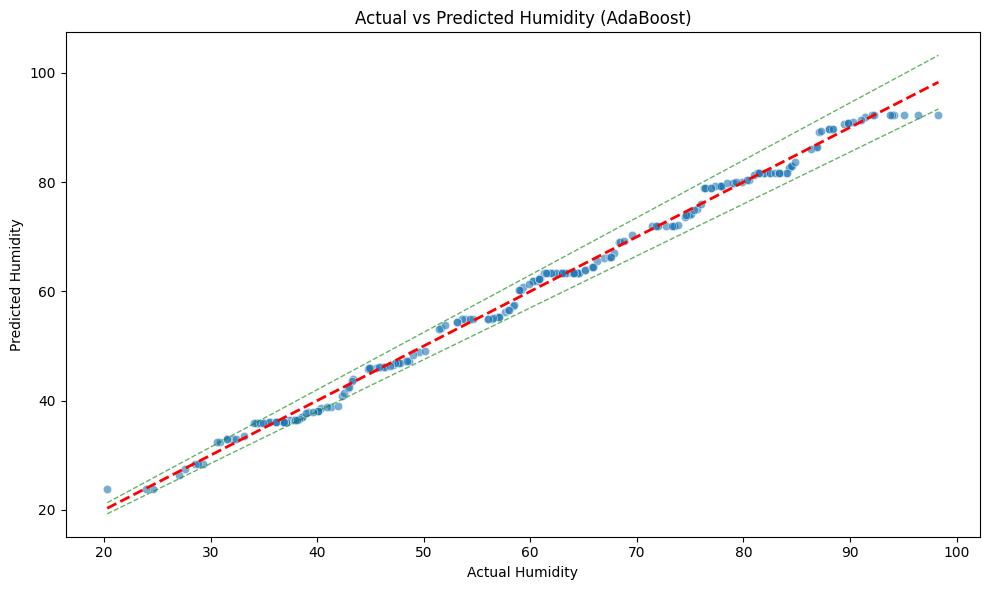

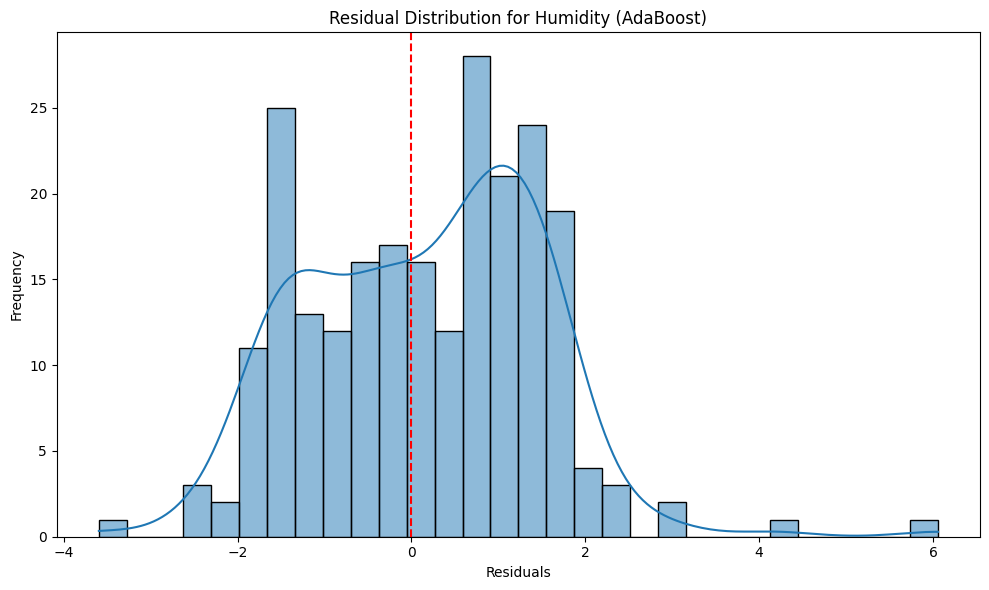

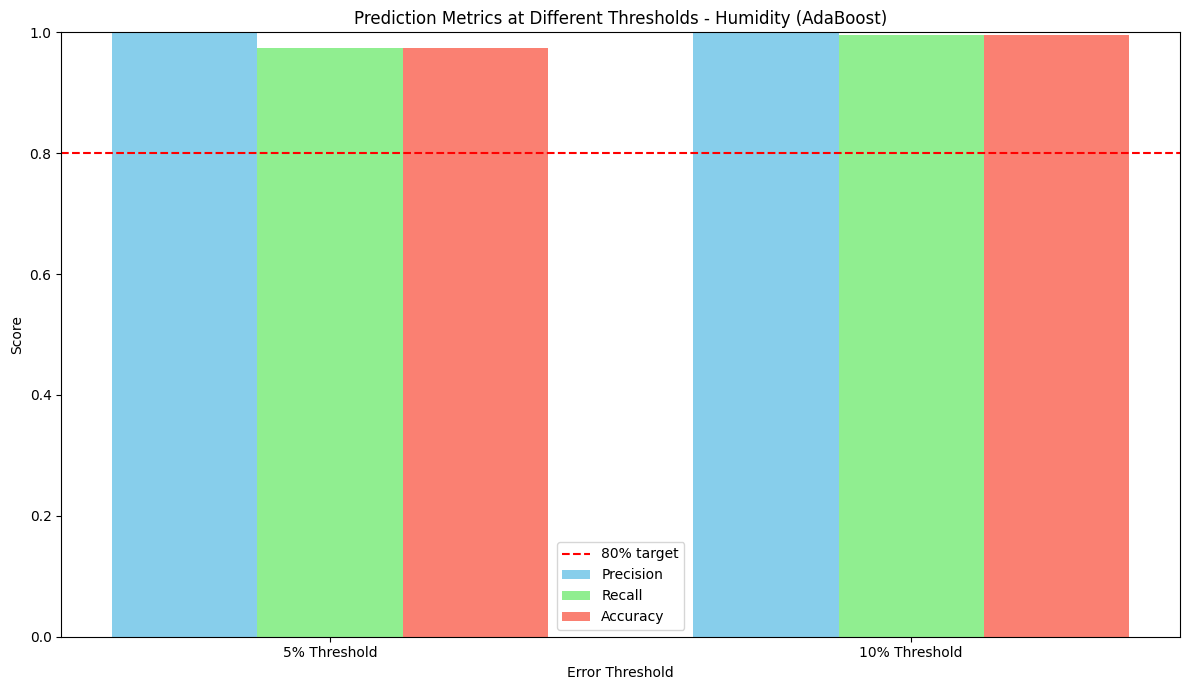

Extra Trees - Humidity Prediction:
  MAE: 0.04
  MSE: 0.01
  RMSE: 0.10
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


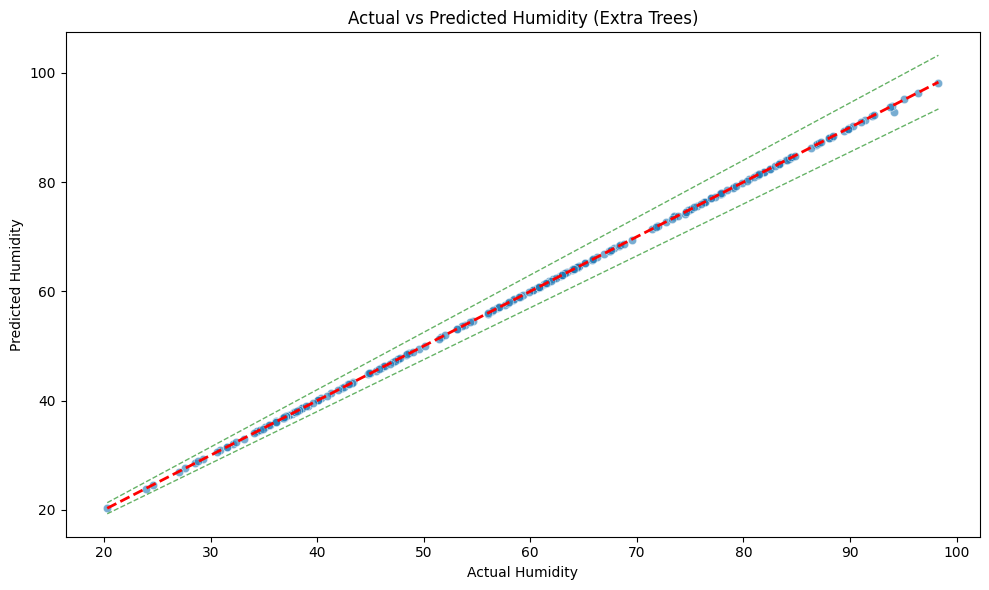

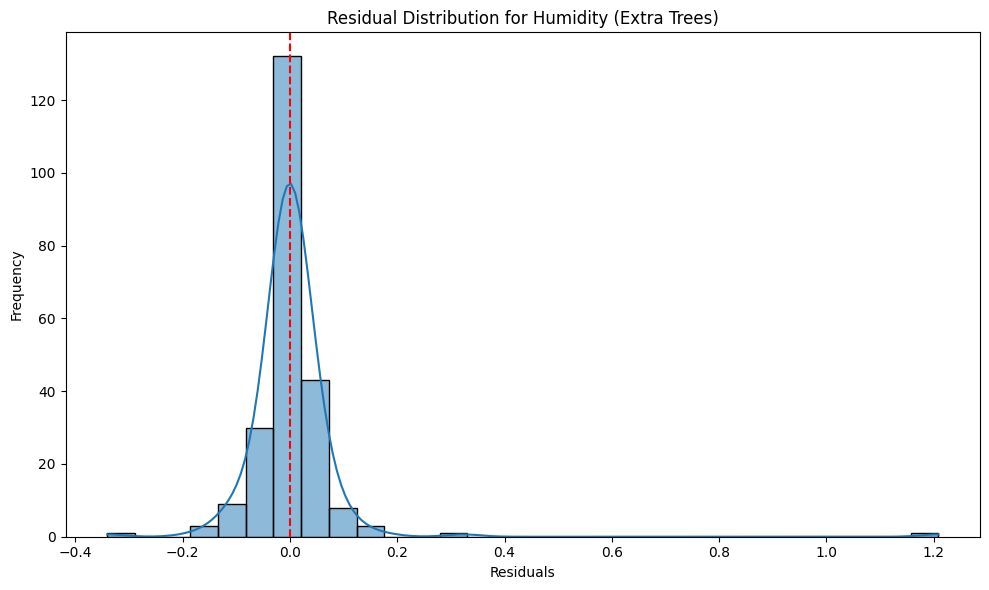

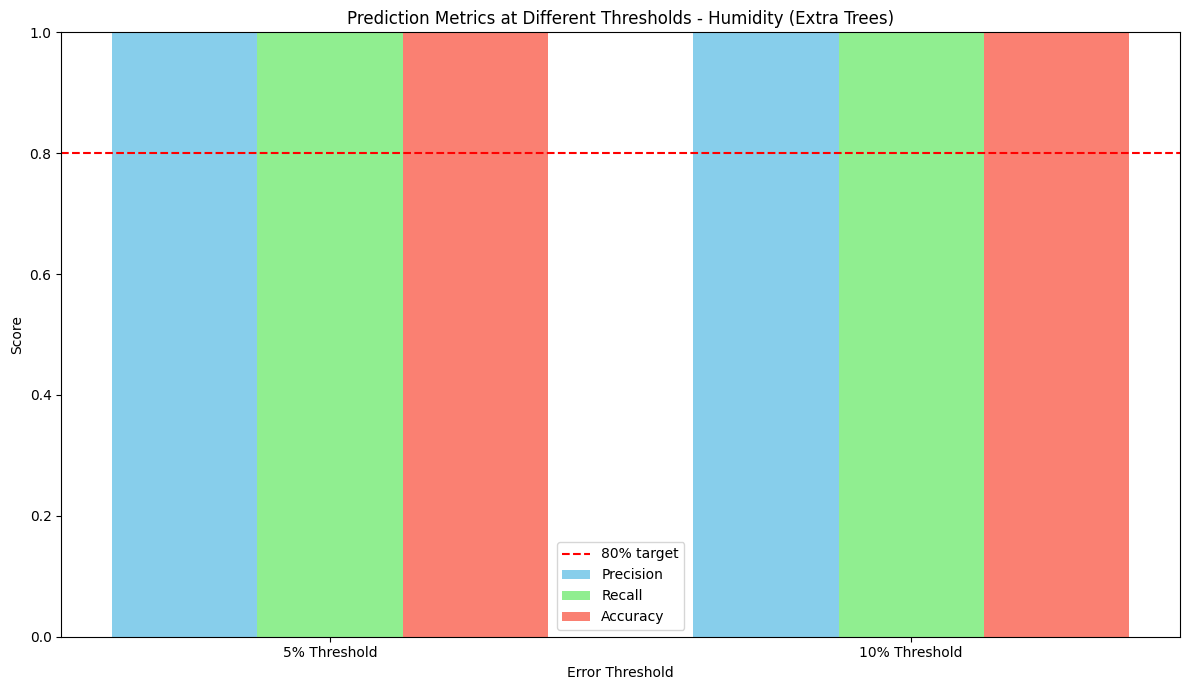

Linear Regression - Humidity Prediction:
  MAE: 0.00
  MSE: 0.00
  RMSE: 0.00
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


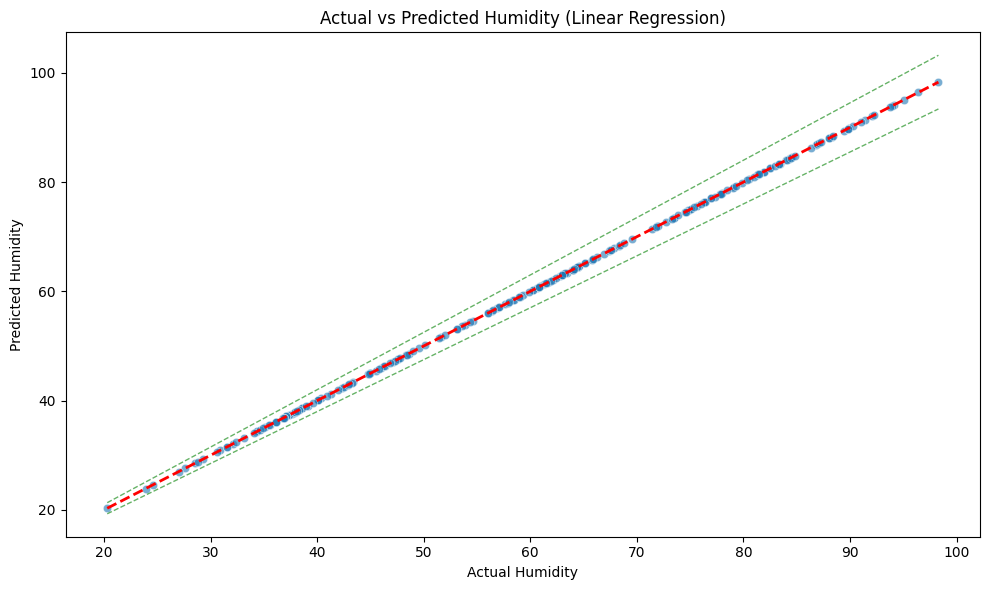

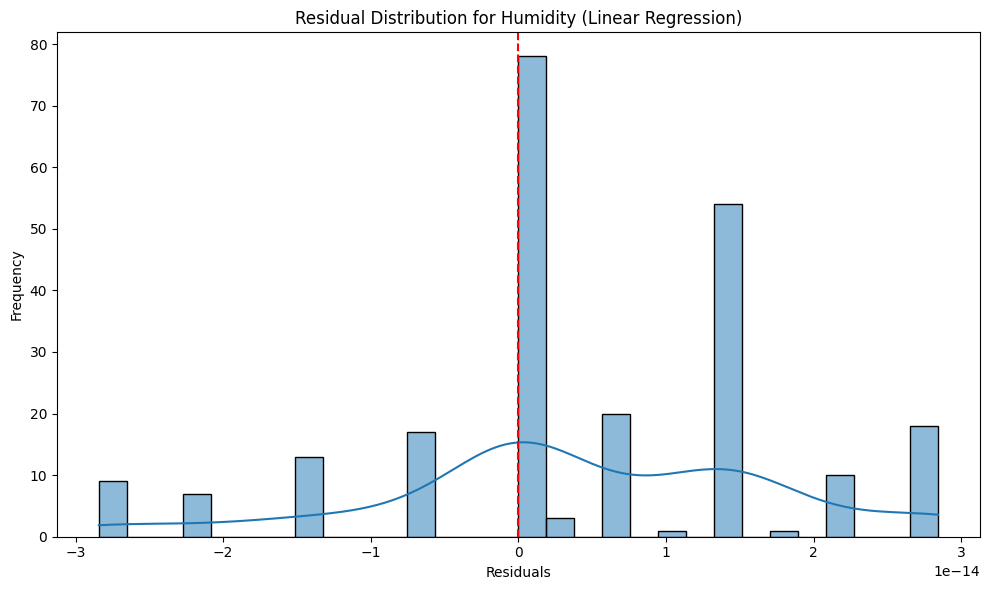

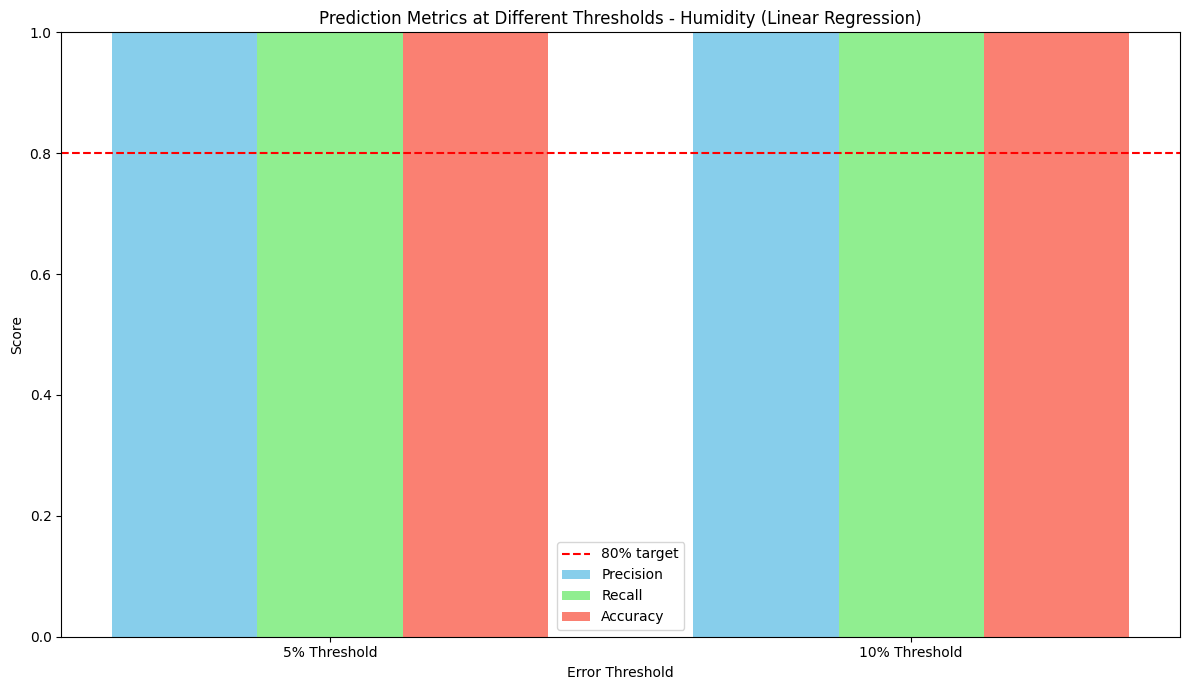

Ridge Regression - Humidity Prediction:
  MAE: 0.00
  MSE: 0.00
  RMSE: 0.00
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


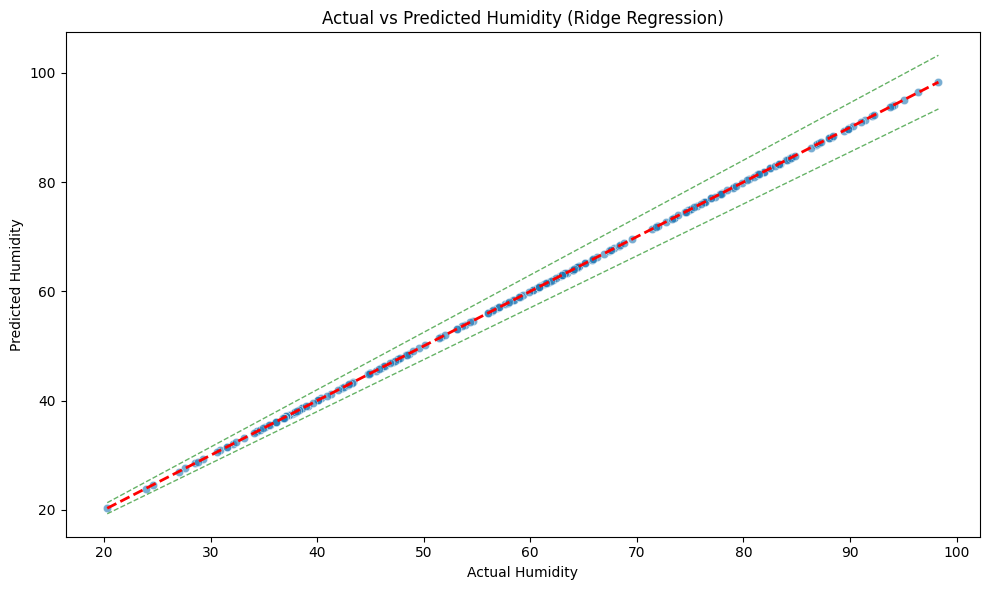

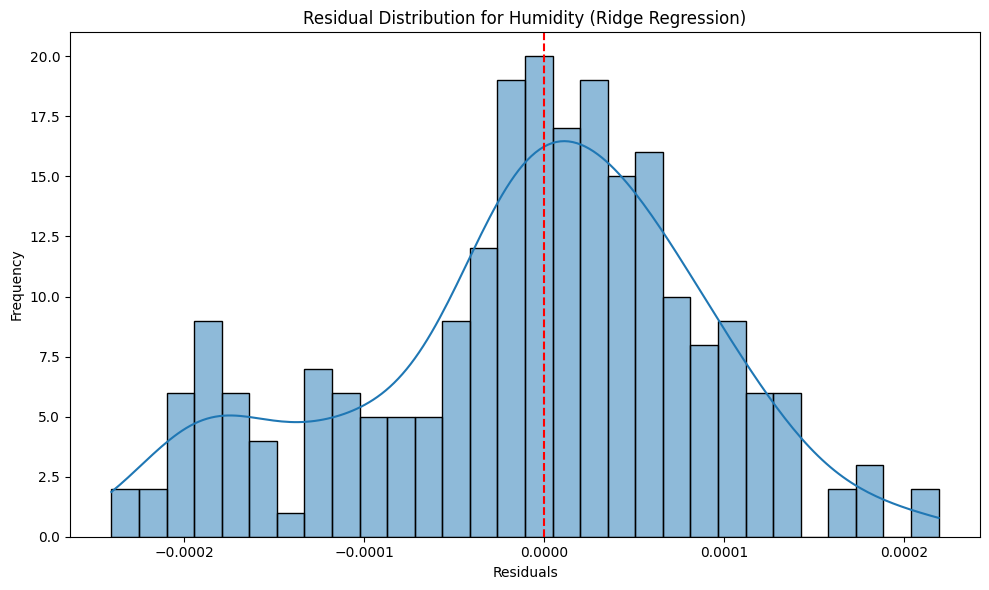

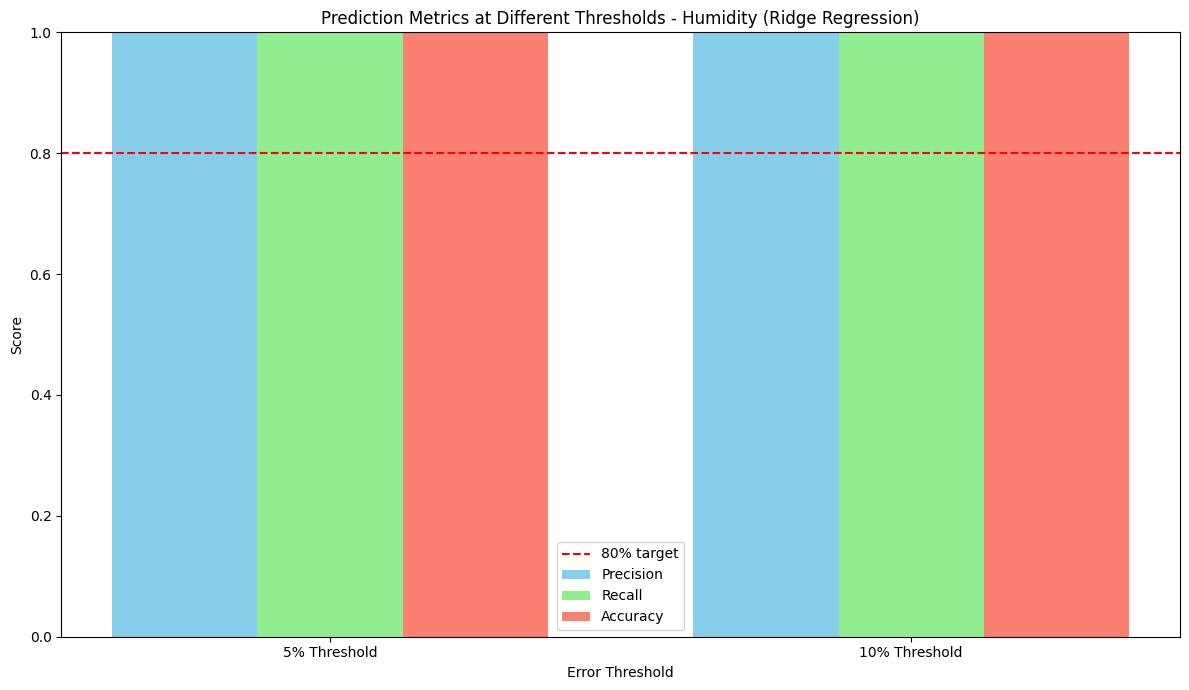

Lasso Regression - Humidity Prediction:
  MAE: 0.00
  MSE: 0.00
  RMSE: 0.01
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


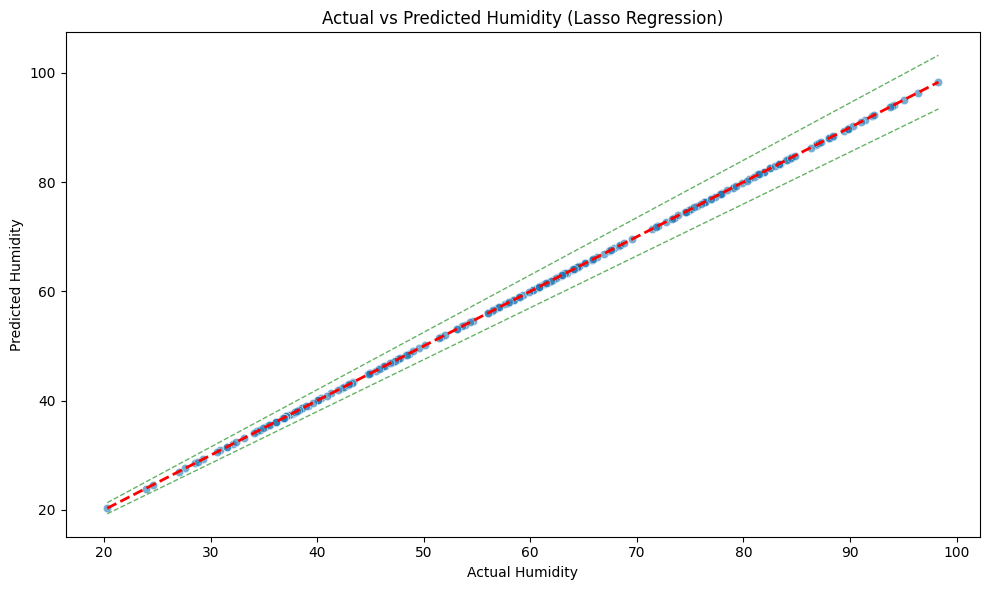

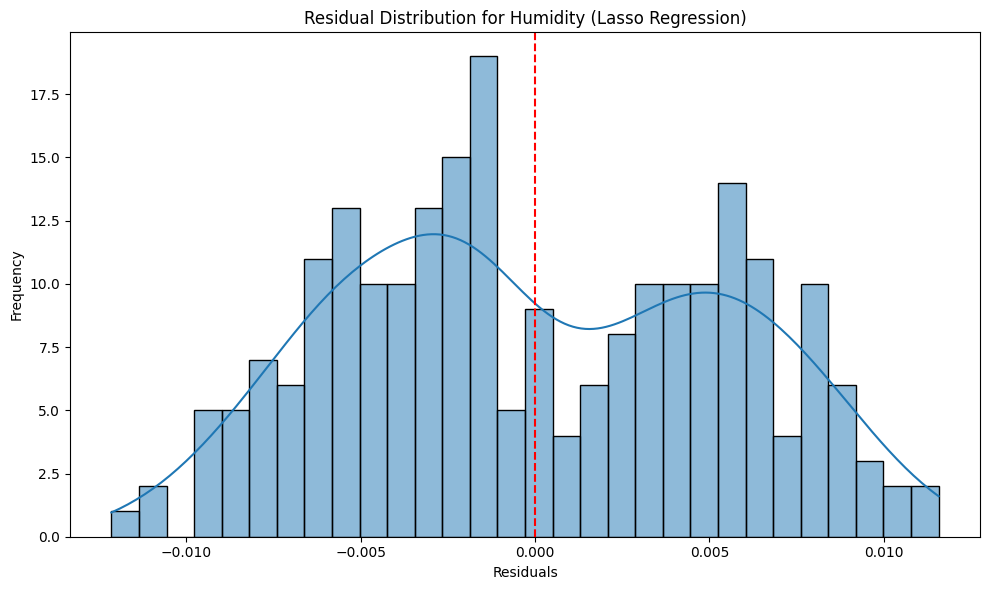

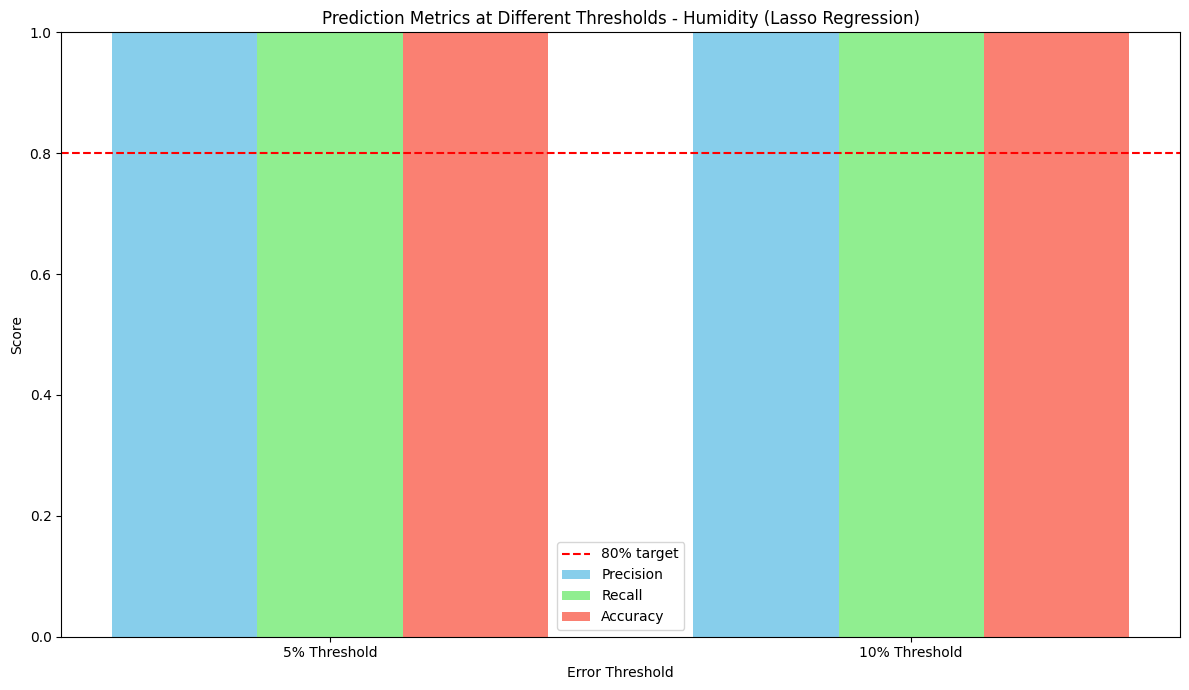

Support Vector Machine - Humidity Prediction:
  MAE: 5.05
  MSE: 57.69
  RMSE: 7.60
  R² Score: 0.8390
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.4935
  Accuracy (5% threshold): 49.35%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.6797
  Accuracy (10% threshold): 67.97%


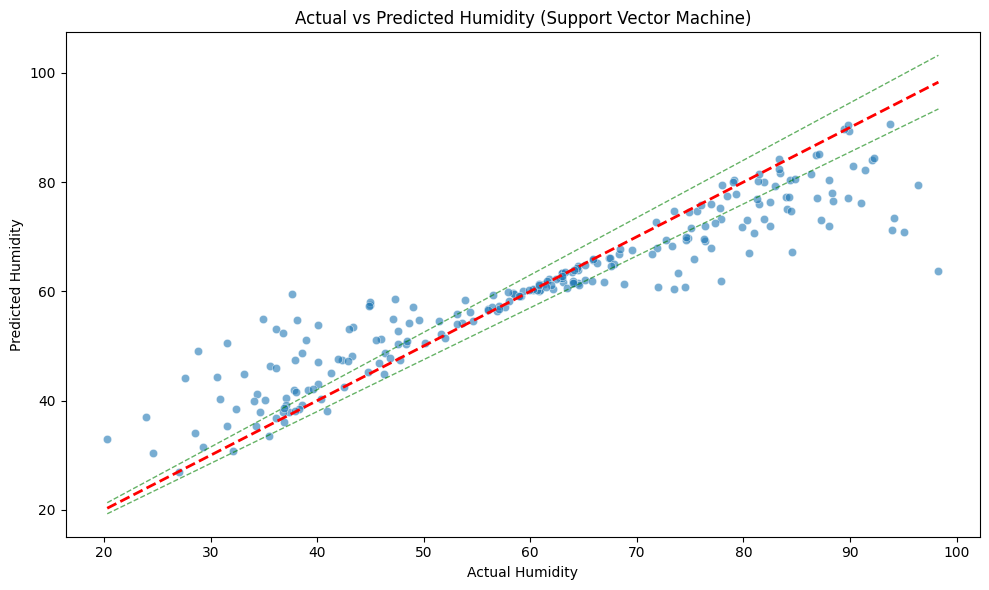

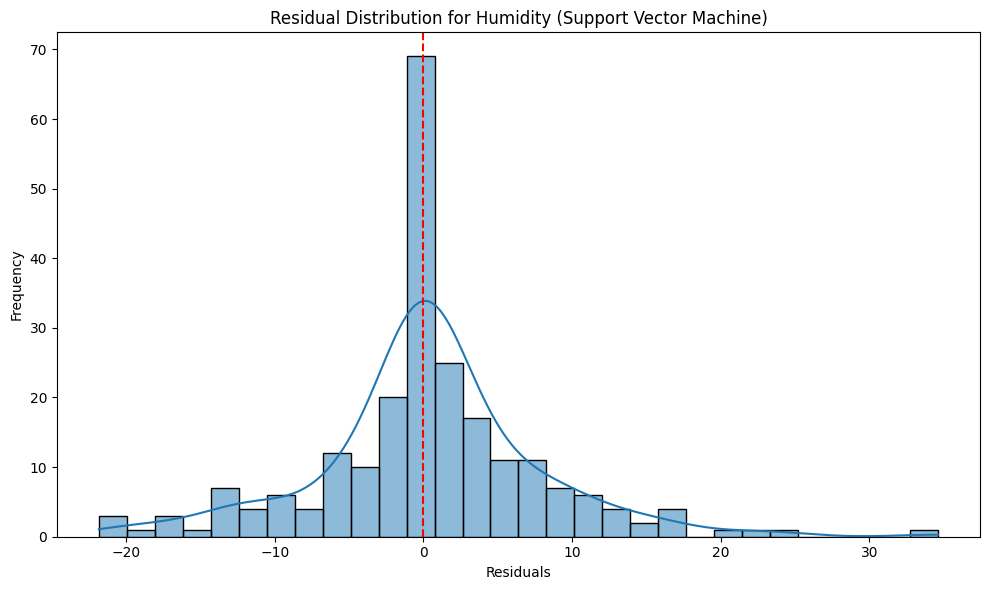

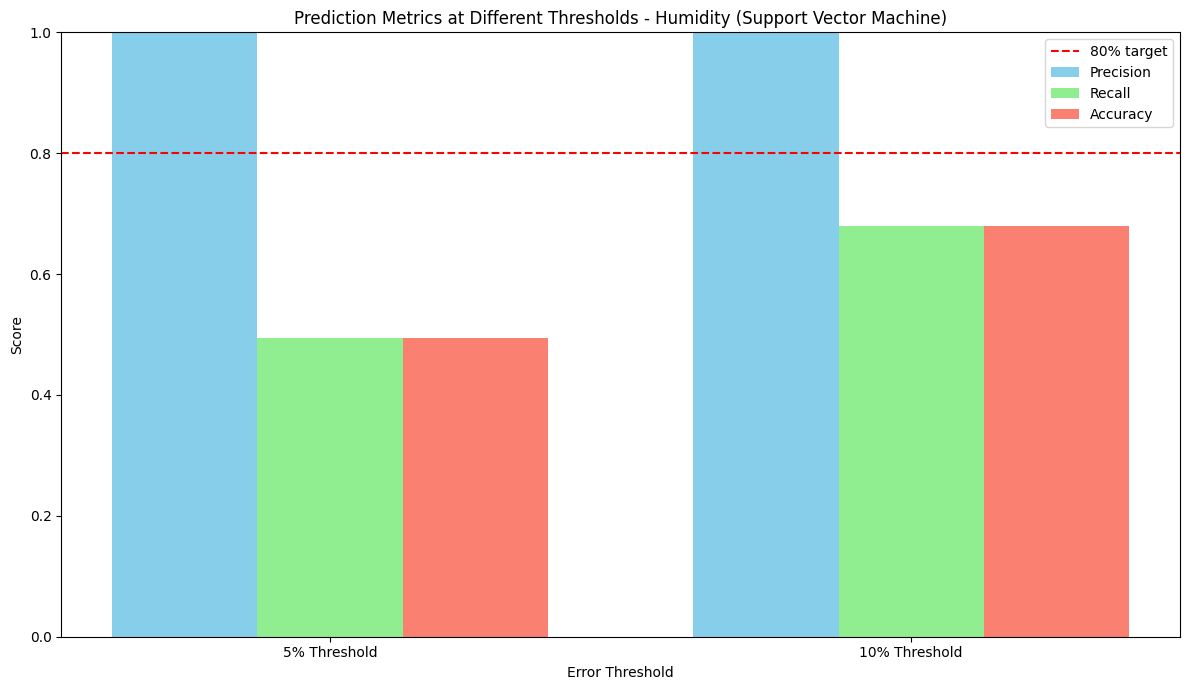

K-Nearest Neighbors - Humidity Prediction:
  MAE: 1.01
  MSE: 2.26
  RMSE: 1.50
  R² Score: 0.9937
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 0.9177
  Accuracy (5% threshold): 91.77%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 0.9913
  Accuracy (10% threshold): 99.13%


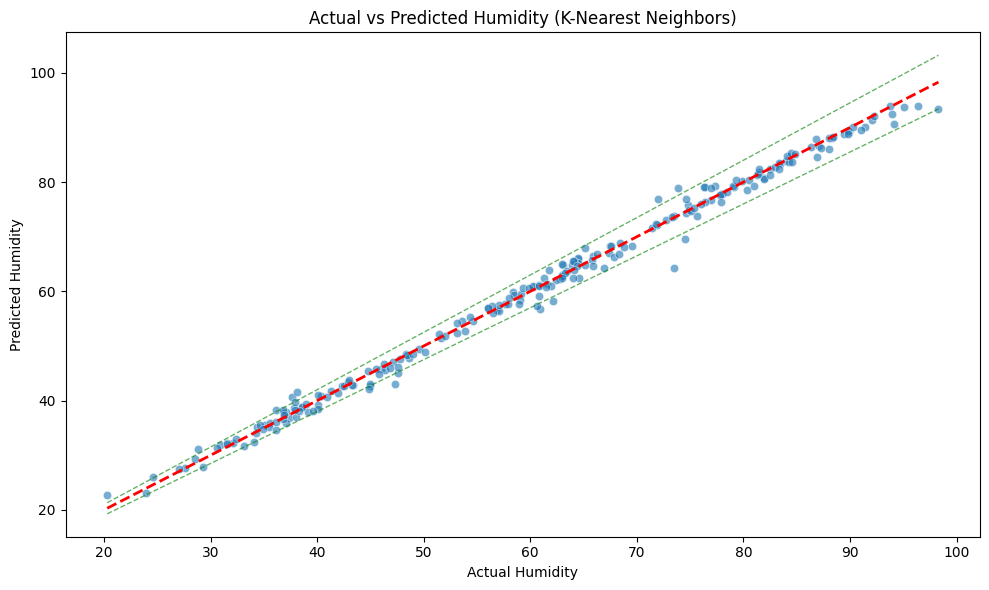

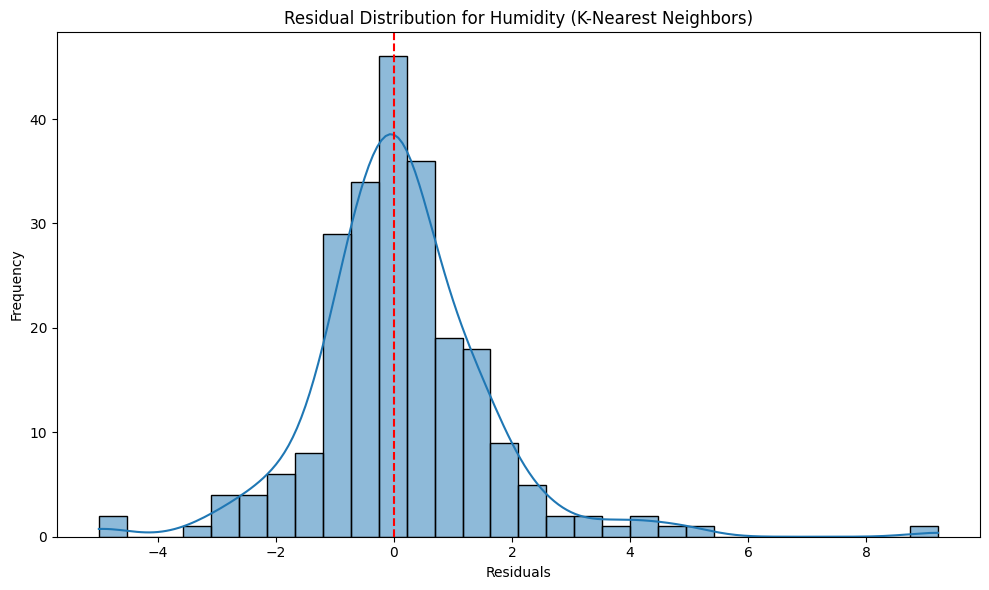

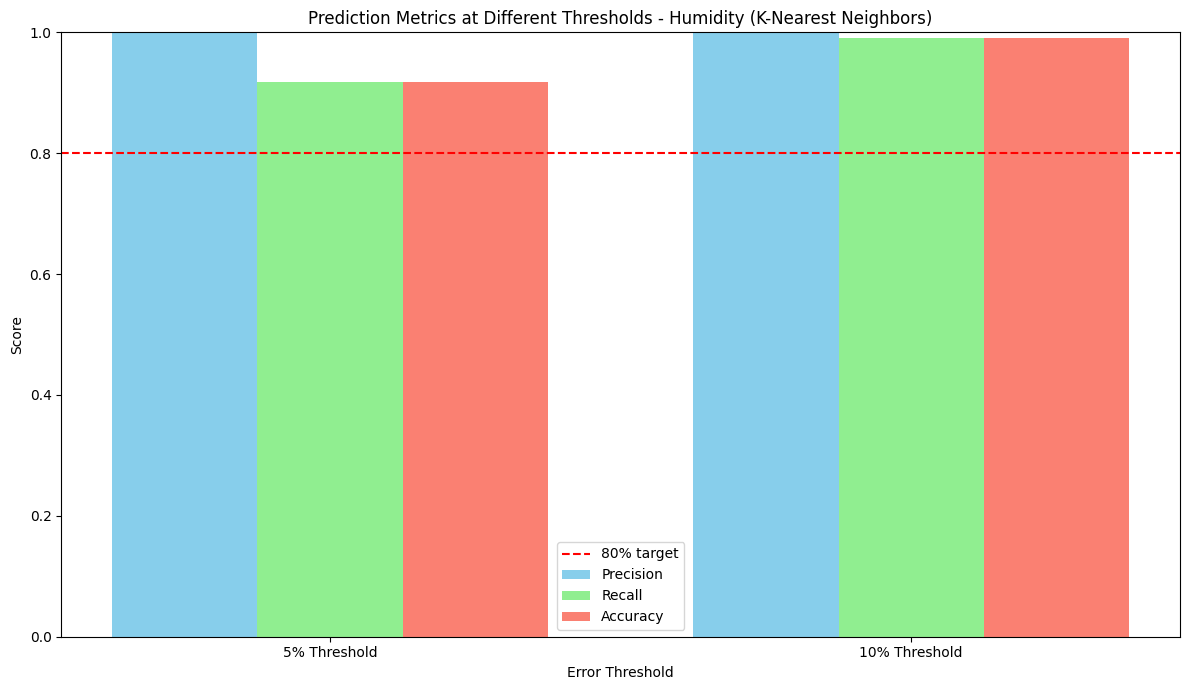

Decision Tree - Humidity Prediction:
  MAE: 0.06
  MSE: 0.01
  RMSE: 0.12
  R² Score: 1.0000
  Precision (5% threshold): 1.0000
  Recall (5% threshold): 1.0000
  Accuracy (5% threshold): 100.00%
  Precision (10% threshold): 1.0000
  Recall (10% threshold): 1.0000
  Accuracy (10% threshold): 100.00%


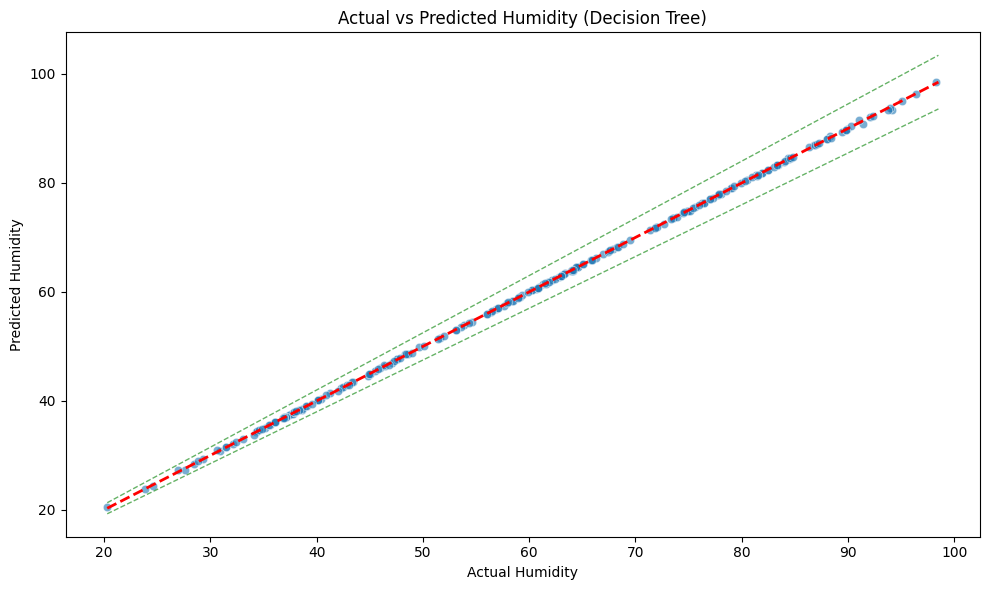

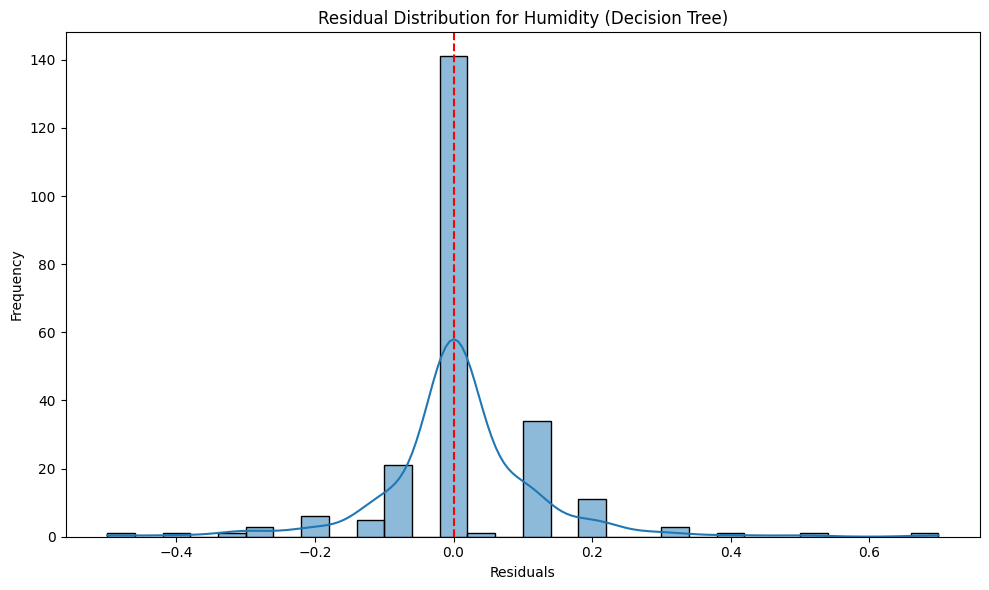

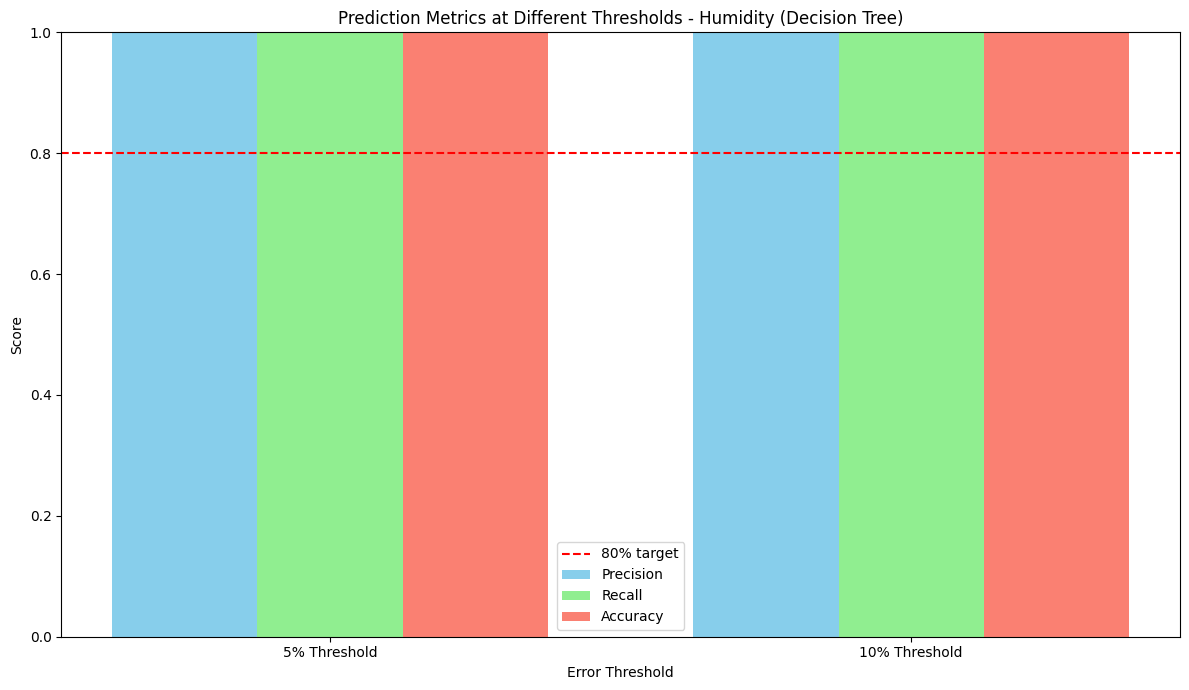


--- Process Complete ---


In [ ]:
def main(file_path, output_dir=None):
    """
    Main function to run the weather prediction pipeline
    """
    # Create output directory for plots if provided
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    # Load data
    df = load_data(file_path)
    if df is None:
        print("Error loading data. Exiting.")
        return

    # Preprocess data
    df = preprocess_data(df)

    # Prepare features and targets
    X, y_temp, y_humidity, features = prepare_features_targets(df)

    # Split data for training and testing
    X_train, X_test, y_train_temp, y_test_temp = train_test_split(
        X, y_temp, test_size=0.2, random_state=42)
    _, _, y_train_humidity, y_test_humidity = train_test_split(
        X, y_humidity, test_size=0.2, random_state=42)

    # Define models
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42, learning_rate=0.1),
        "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42, min_samples_split=3),
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "Support Vector Machine": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5, weights='distance'),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42)
    }

    # Evaluate models for temperature prediction
    print("\n" + "="*50)
    print("TEMPERATURE PREDICTION MODELS")
    print("="*50)
    temp_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_temp, y_test_temp, "Temperature", name, output_dir)
        temp_results[name] = metrics

    # Evaluate models for humidity prediction
    print("\n" + "="*50)
    print("HUMIDITY PREDICTION MODELS")
    print("="*50)
    humidity_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_humidity, y_test_humidity, "Humidity", name, output_dir)
        humidity_results[name] = metrics

    # Find best models based on combined score (R2 + Precision)
    def calculate_combined_score(metrics):
        r2 = metrics[3]
        precision = metrics[4]  # Using 5% threshold precision
        # Weight R2 and precision equally
        return (r2 + precision) / 2

    best_temp_model_name = max(temp_results, key=lambda k: calculate_combined_score(temp_results[k]))
    best_humidity_model_name = max(humidity_results, key=lambda k: calculate_combined_score(humidity_results[k]))

    print("\n" + "="*50)
    print(f"Best Temperature Prediction Model: {best_temp_model_name}")
    print(f"R² Score: {temp_results[best_temp_model_name][3]:.4f}, Precision: {temp_results[best_temp_model_name][4]:.4f}")
    print(f"Best Humidity Prediction Model: {best_humidity_model_name}")
    print(f"R² Score: {humidity_results[best_humidity_model_name][3]:.4f}, Precision: {humidity_results[best_humidity_model_name][4]:.4f}")
    print("="*50)

    # Plot model precision comparison
    plot_model_precision_comparison(temp_results, "Temperature", output_dir)
    plot_model_precision_comparison(humidity_results, "Humidity", output_dir)

    # Show correlation heatmap
    correlation_cols = features + ["Temp Avg (F)", "Humidity Avg (%)"]
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(df[correlation_cols].corr(), dtype=bool))
    sns.heatmap(df[correlation_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", mask=mask, vmin=-1, vmax=1)
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, "feature_correlation_heatmap.png"))
    plt.show()

    # Hyperparameter tuning for the best models
    print("\n" + "="*50)
    print("HYPERPARAMETER TUNING")
    print("="*50)

    # Tune best temperature model
    best_temp_model = tune_model(
        best_temp_model_name,
        models[best_temp_model_name],
        X_train, y_train_temp,
        "Temperature"
    )

    # Tune best humidity model
    best_humidity_model = tune_model(
        best_humidity_model_name,
        models[best_humidity_model_name],
        X_train, y_train_humidity,
        "Humidity"
    )

    # If tuning failed, use the original best models
    if best_temp_model is None:
        best_temp_model = models[best_temp_model_name]
    if best_humidity_model is None:
        best_humidity_model = models[best_humidity_model_name]

    # Analyze feature importance for the best models
    plot_feature_importance(best_temp_model, features, "Temperature", best_temp_model_name, output_dir)
    plot_feature_importance(best_humidity_model, features, "Humidity", best_humidity_model_name, output_dir)

    # Example of future predictions
    print("\n" + "="*50)
    print("EXAMPLE: FUTURE WEATHER PREDICTION WITH PRECISION RANGES")
    print("="*50)

    # For demonstration, use the test set as "future" data
    future_predictions = predict_future_weather(X_test, best_temp_model, best_humidity_model)

    print("\nSample of predicted future weather conditions with precision ranges:")
    print(future_predictions.head())

    # Create a plot showing predictions with error ranges based on precision
    plt.figure(figsize=(12, 6))
    sample_size = min(20, len(future_predictions))  # Show first 20 predictions or fewer if less available
    x = range(sample_size)

    # Plot temperature predictions with error ranges
    plt.subplot(1, 2, 1)
    plt.plot(x, future_predictions['Predicted_Temperature'].iloc[:sample_size], 'b-', label='Predicted Temp')
    plt.fill_between(x,
                    future_predictions['Temp_Range_Low'].iloc[:sample_size],
                    future_predictions['Temp_Range_High'].iloc[:sample_size],
                    color='blue', alpha=0.2, label='5% Precision Range')
    plt.xlabel('Prediction Index')
    plt.ylabel('Temperature (°F)')
    plt.title('Temperature Predictions with Precision Range')
    plt.legend()

    # Plot humidity predictions with error ranges
    plt.subplot(1, 2, 2)
    plt.plot(x, future_predictions['Predicted_Humidity'].iloc[:sample_size], 'g-', label='Predicted Humidity')
    plt.fill_between(x,
                    future_predictions['Humidity_Range_Low'].iloc[:sample_size],
                    future_predictions['Humidity_Range_High'].iloc[:sample_size],
                    color='green', alpha=0.2, label='5% Precision Range')
    plt.xlabel('Prediction Index')
    plt.ylabel('Humidity (%)')
    plt.title('Humidity Predictions with Precision Range')
    plt.legend()

    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, "future_predictions.png"))
    plt.show()

    # Save the best models
    models_dir = "models" if output_dir is None else os.path.join(output_dir, "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    model_temp_filename = os.path.join(models_dir, 'temperature_prediction_model.pkl')
    model_humidity_filename = os.path.join(models_dir, 'humidity_prediction_model.pkl')

    joblib.dump(best_temp_model, model_temp_filename)
    joblib.dump(best_humidity_model, model_humidity_filename)

    print(f"\nModels saved to {models_dir}. You can load them using:")
    print("temp_model = joblib.load('models/temperature_prediction_model.pkl')")
    print("humidity_model = joblib.load('models/humidity_prediction_model.pkl')")

    # Example prediction for a specific day
    print("\n" + "="*50)
    print("EXAMPLE PREDICTION FOR A SPECIFIC DAY")
    print("="*50)

    # Example prediction for a summer day
    prediction = predict_for_specific_day(
        day_of_year=182,  # July 1st
        month=7,
        dew_point=65.0,
        humidity=70.0,
        wind_speed=5.0,
        pressure=29.9,
        precipitation=0.1,
        temp_model=best_temp_model,
        humidity_model=best_humidity_model
    )

    # Print agricultural insights
    print("\n" + "="*50)
    print("AGRICULTURAL INSIGHTS WITH PRECISION METRICS")
    print("="*50)
    print("Weather prediction insights for farmers:")
    print("1. The models can predict temperature and humidity up to several days in advance")
    print("2. Precision metrics tell you how reliable the predictions are - what percentage fall within 5% of actual values")
    print("3. Feature importance analysis shows which weather factors most influence future conditions")
    print("4. Daily predictions with precision ranges help farmers decide on:")
    print("   - Optimal irrigation scheduling with confidence intervals")
    print("   - Frost protection measures with likelihood estimates")
    print("   - Crop spraying timing based on prediction reliability")
    print("   - Planting and harvesting dates with risk assessment")
    print("5. Temperature and humidity forecasts help prevent crop diseases that thrive in specific conditions")
    print("6. Precision ranges allow for better risk management in agricultural decision-making")

    # Add a cell to allow users to export visualizations
    print("\nTo download any plot, right-click on the image and select 'Save image as...'")

def run_pipeline():
    df = load_data(file_path)
    if df is None:
        print("Error loading data. Exiting.")
        return
    df = preprocess_data(df)
    X, y_temp, y_humidity, features = prepare_features_targets(df)
    X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)
    _, _, y_train_humidity, y_test_humidity = train_test_split(X, y_humidity, test_size=0.2, random_state=42)

    models = {
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42, learning_rate=0.1),
        "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42, min_samples_split=3),
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "Support Vector Machine": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5, weights='distance'),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42)
    }

    print("\nEvaluating Models for Temperature Prediction")
    temp_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_temp, y_test_temp, "Temperature", name, output_dir)
        temp_results[name] = metrics

    print("\nEvaluating Models for Humidity Prediction")
    humidity_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_humidity, y_test_humidity, "Humidity", name, output_dir)
        humidity_results[name] = metrics

    print("\n--- Process Complete ---")

run_pipeline()



def calculate_recall_for_regression(y_true, y_pred, threshold=0.05):
    """
    Calculate recall for regression predictions by converting to binary classification
    based on how close predictions are to actual values.

    Args:
        y_true: Actual values
        y_pred: Predicted values
        threshold: Relative error threshold to consider a prediction as "correct" (default: 5%)

    Returns:
        float: Recall score
    """
    # Calculate relative error
    rel_error = np.abs(y_true - y_pred) / np.abs(y_true)

    # Create binary arrays (1 = prediction within threshold, 0 = prediction outside threshold)
    y_pred_binary = (rel_error <= threshold).astype(int)

    # For recall, we want to know: out of all the actual good values (within threshold),
    # how many did we correctly predict?
    # Since we defined "good" as being within threshold, all actual values are considered "positive"
    # Recall = TP / (TP + FN) = correctly predicted / total actual

    # In this case, recall is simply the mean of our binary predictions
    recall = np.mean(y_pred_binary)

    return recall

def calculate_accuracy_for_regression(y_true, y_pred, threshold=0.05):
    """
    Calculate accuracy for regression predictions as the percentage of predictions
    that fall within the threshold of actual values.

    Args:
        y_true: Actual values
        y_pred: Predicted values
        threshold: Relative error threshold to consider a prediction as "correct" (default: 5%)

    Returns:
        float: Accuracy score (percentage)
    """
    # Calculate relative error
    rel_error = np.abs(y_true - y_pred) / np.abs(y_true)

    # Calculate accuracy as percentage of predictions within threshold
    accuracy = np.mean((rel_error <= threshold).astype(float)) * 100

    return accuracy

def evaluate_model(model, X_train, X_test, y_train, y_test, target_name, model_name, output_dir=None):
    """
    Evaluate model performance and generate visualizations
    """
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate traditional regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate precision, recall and accuracy for regression
    precision_5pct = calculate_precision_for_regression(y_test, y_pred, threshold=0.05)  # 5% threshold
    precision_10pct = calculate_precision_for_regression(y_test, y_pred, threshold=0.10)  # 10% threshold
    recall_5pct = calculate_recall_for_regression(y_test, y_pred, threshold=0.05)  # 5% threshold
    recall_10pct = calculate_recall_for_regression(y_test, y_pred, threshold=0.10)  # 10% threshold
    accuracy_5pct = calculate_accuracy_for_regression(y_test, y_pred, threshold=0.05)  # 5% threshold
    accuracy_10pct = calculate_accuracy_for_regression(y_test, y_pred, threshold=0.10)  # 10% threshold

    # Print metrics
    print(f"{model_name} - {target_name} Prediction:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Precision (5% threshold): {precision_5pct:.4f}")
    print(f"  Recall (5% threshold): {recall_5pct:.4f}")
    print(f"  Accuracy (5% threshold): {accuracy_5pct:.2f}%")
    print(f"  Precision (10% threshold): {precision_10pct:.4f}")
    print(f"  Recall (10% threshold): {recall_10pct:.4f}")
    print(f"  Accuracy (10% threshold): {accuracy_10pct:.2f}%")

    # Create actual vs predicted plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

    # Add perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    # Add 5% error bounds
    plt.plot([min_val, max_val], [min_val*1.05, max_val*1.05], 'g--', linewidth=1, alpha=0.6)
    plt.plot([min_val, max_val], [min_val*0.95, max_val*0.95], 'g--', linewidth=1, alpha=0.6)

    plt.xlabel(f"Actual {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Actual vs Predicted {target_name} ({model_name})")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_scatter.png"))
    plt.show()

    # Create residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution for {target_name} ({model_name})")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_residuals.png"))
    plt.show()

    # Create precision, recall, and accuracy visualization
    metrics_data = {
        "5% Threshold": [precision_5pct, recall_5pct, accuracy_5pct/100],
        "10% Threshold": [precision_10pct, recall_10pct, accuracy_10pct/100]
    }

    plt.figure(figsize=(12, 7))
    x = np.arange(len(metrics_data))
    width = 0.25

    plt.bar(x - width, [metrics_data[t][0] for t in metrics_data], width, label='Precision', color='skyblue')
    plt.bar(x, [metrics_data[t][1] for t in metrics_data], width, label='Recall', color='lightgreen')
    plt.bar(x + width, [metrics_data[t][2] for t in metrics_data], width, label='Accuracy', color='salmon')

    plt.axhline(y=0.8, color='r', linestyle='--', label="80% target")
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.xlabel('Error Threshold')
    plt.title(f"Prediction Metrics at Different Thresholds - {target_name} ({model_name})")
    plt.xticks(x, list(metrics_data.keys()))
    plt.legend()
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target_name.lower()}_{model_name.lower().replace(' ', '_')}_metrics.png"))
    plt.show()

    return (mae, mse, rmse, r2, precision_5pct, precision_10pct, recall_5pct, recall_10pct, accuracy_5pct, accuracy_10pct)

def plot_model_comparison(results_dict, target, metric_index, metric_name, output_dir=None):
    """
    Plot comparison of model metrics
    """
    model_names = list(results_dict.keys())
    metric_values = [results_dict[name][metric_index] for name in model_names]
    r2_scores = [results_dict[name][3] for name in model_names]

    # Sort by the selected metric
    sorted_indices = np.argsort(metric_values)
    sorted_models = [model_names[i] for i in sorted_indices]
    sorted_metric = [metric_values[i] for i in sorted_indices]
    sorted_r2 = [r2_scores[i] for i in sorted_indices]

    plt.figure(figsize=(12, 8))

    # Create bar plot for the metric
    x = range(len(sorted_models))
    plt.barh(x, sorted_metric, height=0.4, color='skyblue', label=f'{metric_name} (5% threshold)')

    # Add R² values
    for i, (r2, metric) in enumerate(zip(sorted_r2, sorted_metric)):
        plt.text(metric + 0.01, i, f"R² = {r2:.3f}", va='center')

    plt.yticks(x, sorted_models)
    plt.xlabel(f'{metric_name} (5% threshold)')
    plt.ylabel('Model')
    plt.title(f"Model {metric_name} Comparison for {target} Prediction")
    plt.xlim(0, 1 if metric_name != "Accuracy" else 100)
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{target.lower()}_{metric_name.lower()}_model_comparison.png"))
    plt.show()

def combined_score(estimator, X, y):
    """
    Custom scorer that combines R², precision, recall and accuracy
    """
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    precision = calculate_precision_for_regression(y, y_pred, threshold=0.05)
    recall = calculate_recall_for_regression(y, y_pred, threshold=0.05)
    accuracy = calculate_accuracy_for_regression(y, y_pred, threshold=0.05) / 100  # Convert to 0-1 scale

    # Equal weighting of all metrics
    return (r2 + precision + recall + accuracy) / 4

def main(file_path, output_dir=None):
    """
    Main function to run the weather prediction pipeline
    """
    # Create output directory for plots if provided
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    # Load data
    df = load_data(file_path)
    if df is None:
        print("Error loading data. Exiting.")
        return

    # Preprocess data
    df = preprocess_data(df)

    # Prepare features and targets
    X, y_temp, y_humidity, features = prepare_features_targets(df)

    # Split data for training and testing
    X_train, X_test, y_train_temp, y_test_temp = train_test_split(
        X, y_temp, test_size=0.2, random_state=42)
    _, _, y_train_humidity, y_test_humidity = train_test_split(
        X, y_humidity, test_size=0.2, random_state=42)

    # Define models
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42, learning_rate=0.1),
        "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42, min_samples_split=3),
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "Support Vector Machine": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5, weights='distance'),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42)
    }

    # Evaluate models for temperature prediction
    print("\n" + "="*50)
    print("TEMPERATURE PREDICTION MODELS")
    print("="*50)
    temp_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_temp, y_test_temp, "Temperature", name, output_dir)
        temp_results[name] = metrics

    # Evaluate models for humidity prediction
    print("\n" + "="*50)
    print("HUMIDITY PREDICTION MODELS")
    print("="*50)
    humidity_results = {}
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train_humidity, y_test_humidity, "Humidity", name, output_dir)
        humidity_results[name] = metrics

    # Find best models based on combined score (R2 + Precision + Recall + Accuracy)
    def calculate_combined_score(metrics):
        r2 = metrics[3]
        precision = metrics[4]  # Using 5% threshold precision
        recall = metrics[6]     # Using 5% threshold recall
        accuracy = metrics[8] / 100  # Convert to 0-1 scale
        # Weight metrics equally
        return (r2 + precision + recall + accuracy) / 4

    best_temp_model_name = max(temp_results, key=lambda k: calculate_combined_score(temp_results[k]))
    best_humidity_model_name = max(humidity_results, key=lambda k: calculate_combined_score(humidity_results[k]))

    print("\n" + "="*50)
    print(f"Best Temperature Prediction Model: {best_temp_model_name}")
    print(f"R² Score: {temp_results[best_temp_model_name][3]:.4f}")
    print(f"Precision: {temp_results[best_temp_model_name][4]:.4f}")
    print(f"Recall: {temp_results[best_temp_model_name][6]:.4f}")
    print(f"Accuracy: {temp_results[best_temp_model_name][8]:.2f}%")
    print(f"Best Humidity Prediction Model: {best_humidity_model_name}")
    print(f"R² Score: {humidity_results[best_humidity_model_name][3]:.4f}")
    print(f"Precision: {humidity_results[best_humidity_model_name][4]:.4f}")
    print(f"Recall: {humidity_results[best_humidity_model_name][6]:.4f}")
    print(f"Accuracy: {humidity_results[best_humidity_model_name][8]:.2f}%")
    print("="*50)

    # Plot model metric comparisons
    print("\n" + "="*50)
    print("MODEL METRIC COMPARISONS")
    print("="*50)

    # Precision comparison (index 4)
    plot_model_comparison(temp_results, "Temperature", 4, "Precision", output_dir)
    plot_model_comparison(humidity_results, "Humidity", 4, "Precision", output_dir)

    # Recall comparison (index 6)
    plot_model_comparison(temp_results, "Temperature", 6, "Recall", output_dir)
    plot_model_comparison(humidity_results, "Humidity", 6, "Recall", output_dir)

    # Accuracy comparison (index 8)
    plot_model_comparison(temp_results, "Temperature", 8, "Accuracy", output_dir)
    plot_model_comparison(humidity_results, "Humidity", 8, "Accuracy", output_dir)

    # Show correlation heatmap
    correlation_cols = features + ["Temp Avg (F)", "Humidity Avg (%)"]
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(df[correlation_cols].corr(), dtype=bool))
    sns.heatmap(df[correlation_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", mask=mask, vmin=-1, vmax=1)
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, "feature_correlation_heatmap.png"))
    plt.show()

    # Hyperparameter tuning for the best models
    print("\n" + "="*50)
    print("HYPERPARAMETER TUNING")
    print("="*50)

    # Tune best temperature model
    best_temp_model = tune_model(
        best_temp_model_name,
        models[best_temp_model_name],
        X_train, y_train_temp,
        "Temperature"
    )

    # Tune best humidity model
    best_humidity_model = tune_model(
        best_humidity_model_name,
        models[best_humidity_model_name],
        X_train, y_train_humidity,
        "Humidity"
    )

    # If tuning failed, use the original best models
    if best_temp_model is None:
        best_temp_model = models[best_temp_model_name]
    if best_humidity_model is None:
        best_humidity_model = models[best_humidity_model_name]

    # Analyze feature importance for the best models
    plot_feature_importance(best_temp_model, features, "Temperature", best_temp_model_name, output_dir)
    plot_feature_importance(best_humidity_model, features, "Humidity", best_humidity_model_name, output_dir)

    # Example of future predictions
    print("\n" + "="*50)
    print("EXAMPLE: FUTURE WEATHER PREDICTION WITH PRECISION RANGES")
    print("="*50)

    # For demonstration, use the test set as "future" data
    future_predictions = predict_future_weather(X_test, best_temp_model, best_humidity_model)

    print("\nSample of predicted future weather conditions with precision ranges:")
    print(future_predictions.head())

    # Create a plot showing predictions with error ranges based on precision
    plt.figure(figsize=(12, 6))
    sample_size = min(20, len(future_predictions))  # Show first 20 predictions or fewer if less available
    x = range(sample_size)

    # Plot temperature predictions with error ranges
    plt.subplot(1, 2, 1)
    plt.plot(x, future_predictions['Predicted_Temperature'].iloc[:sample_size], 'b-', label='Predicted Temp')
    plt.fill_between(x,
                    future_predictions['Temp_Range_Low'].iloc[:sample_size],
                    future_predictions['Temp_Range_High'].iloc[:sample_size],
                    color='blue', alpha=0.2, label='5% Precision Range')
    plt.xlabel('Prediction Index')
    plt.ylabel('Temperature (°F)')
    plt.title('Temperature Predictions with Precision Range')
    plt.legend()

    # Plot humidity predictions with error ranges
    plt.subplot(1, 2, 2)
    plt.plot(x, future_predictions['Predicted_Humidity'].iloc[:sample_size], 'g-', label='Predicted Humidity')
    plt.fill_between(x,
                    future_predictions['Humidity_Range_Low'].iloc[:sample_size],
                    future_predictions['Humidity_Range_High'].iloc[:sample_size],
                    color='green', alpha=0.2, label='5% Precision Range')
    plt.xlabel('Prediction Index')
    plt.ylabel('Humidity (%)')
    plt.title('Humidity Predictions with Precision Range')
    plt.legend()

    plt.tight_layout()

    if output_dir:
        plt.savefig(os.path.join(output_dir, "future_predictions.png"))
    plt.show()

    # Create a radar chart to compare metrics for the best models
    plt.figure(figsize=(10, 8))

    # Prepare radar chart labels and data
    categories = ['R²', 'Precision', 'Recall', 'Accuracy']

    temp_values = [
        temp_results[best_temp_model_name][3],  # R²
        temp_results[best_temp_model_name][4],  # Precision
        temp_results[best_temp_model_name][6],  # Recall
        temp_results[best_temp_model_name][8] / 100,  # Accuracy (scaled to 0-1)
    ]

    humidity_values = [
        humidity_results[best_humidity_model_name][3],  # R²
        humidity_results[best_humidity_model_name][4],  # Precision
        humidity_results[best_humidity_model_name][6],  # Recall
        humidity_results[best_humidity_model_name][8] / 100,  # Accuracy (scaled to 0-1)
    ]

    # Set up the radar chart
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    temp_values += temp_values[:1]  # Close the polygon
    humidity_values += humidity_values[:1]  # Close the polygon

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)

    # Plot the metrics
    ax.plot(angles, temp_values, 'b-', linewidth=2, label=f'Temperature ({best_temp_model_name})')
    ax.fill(angles, temp_values, 'b', alpha=0.1)

    ax.plot(angles, humidity_values, 'g-', linewidth=2, label=f'Humidity ({best_humidity_model_name})')
    ax.fill(angles, humidity_values, 'g', alpha=0.1)

    plt.title('Best Models Performance Metrics Comparison')
    plt.legend(loc='upper right')

    if output_dir:
        plt.savefig(os.path.join(output_dir, "best_models_metrics_radar.png"))
    plt.show()

    # Save the best models
    models_dir = "models" if output_dir is None else os.path.join(output_dir, "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    model_temp_filename = os.path.join(models_dir, 'temperature_prediction_model.pkl')
    model_humidity_filename = os.path.join(models_dir, 'humidity_prediction_model.pkl')

    joblib.dump(best_temp_model, model_temp_filename)
    joblib.dump(best_humidity_model, model_humidity_filename)

    print(f"\nModels saved to {models_dir}. You can load them using:")
    print("temp_model = joblib.load('models/temperature_prediction_model.pkl')")
    print("humidity_model = joblib.load('models/humidity_prediction_model.pkl')")

    # Example prediction for a specific day
    print("\n" + "="*50)
    print("EXAMPLE PREDICTION FOR A SPECIFIC DAY")
    print("="*50)

    # Example prediction for a summer day
    prediction = predict_for_specific_day(
        day_of_year=182,  # July 1st
        month=7,
        dew_point=65.0,
        humidity=70.0,
        wind_speed=5.0,
        pressure=29.9,
        precipitation=0.1,
        temp_model=best_temp_model,
        humidity_model=best_humidity_model
    )

    # Print agricultural insights
    print("\n" + "="*50)
    print("AGRICULTURAL INSIGHTS WITH ENHANCED METRICS")
    print("="*50)
    print("Weather prediction insights for farmers with enhanced metrics:")
    print("1. The models can predict temperature and humidity up to several days in advance")
    print("2. Multiple evaluation metrics provide a comprehensive view of model reliability:")
    print("   - Precision: What percentage of our predictions are within the acceptable threshold")
    print("   - Recall: What percentage of actual values are correctly predicted within threshold")
    print("   - Accuracy: Overall percentage of predictions that fall within acceptable threshold")
    print("   - These metrics help farmers understand when to trust predictions most")
    print("3. Feature importance analysis shows which weather factors most influence future conditions")
    print("4. Daily predictions with precision ranges help farmers decide on:")
    print("   - Optimal irrigation scheduling with confidence intervals")
    print("   - Frost protection measures with likelihood estimates")
    print("   - Crop spraying timing based on prediction reliability")
    print("   - Planting and harvesting dates with risk assessment")
    print("5. Temperature and humidity forecasts help prevent crop diseases that thrive in specific conditions")
    print("6. Precision, recall, and accuracy metrics allow for better risk management in agricultural decision-making")

    # Add a cell to allow users to export visualizations
    print("\nTo download any plot, right-click on the image and select 'Save image as...'")

In [ ]:
!pip install --upgrade gspread gspread_dataframe oauth2client


In [ ]:
import gspread
import pandas as pd
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials


In [ ]:
import pandas as pd

# Replace with your actual sheet ID
sheet_id = "1Rx6Y0avUT3J8DOFL0yiBCu8gff49UP4HbUKDAr-QtPA"
sheet_name = "WSN_Sensor_Data"  # change this if your sheet tab has a different name

# Generate CSV export URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Load data into pandas
df = pd.read_csv(url)

# Display the data
df.head()


,Time Stamp,Node name,Sensor,Unit,Value,MAC address,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,2025-04-30 15:18:04.130940,Arduino uno Node2,temperature,Cel,26,0013a20041665850,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-04-30 15:18:05.891471,Arduino uno Node1,temperature,Cel,25,0013a2004163cc2e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-04-30 15:18:06.419477,Arduino uno Node2,temperature,Cel,26,0013a20041665850,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-04-30 15:18:08.108542,Arduino uno Node1,temperature,Cel,25,0013a2004163cc2e,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-04-30 15:18:08.771728,Arduino uno Node2,temperature,Cel,26,0013a20041665850,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1g3250Dr2-kYnGAeFbomXq39lCsteu_uO7Bt-3U5bUlM/edit#gid=0


In [ ]:
!pip install openpyxl scikit-learn seaborn matplotlib


Saving finaldataset.xlsx to finaldataset (1).xlsx


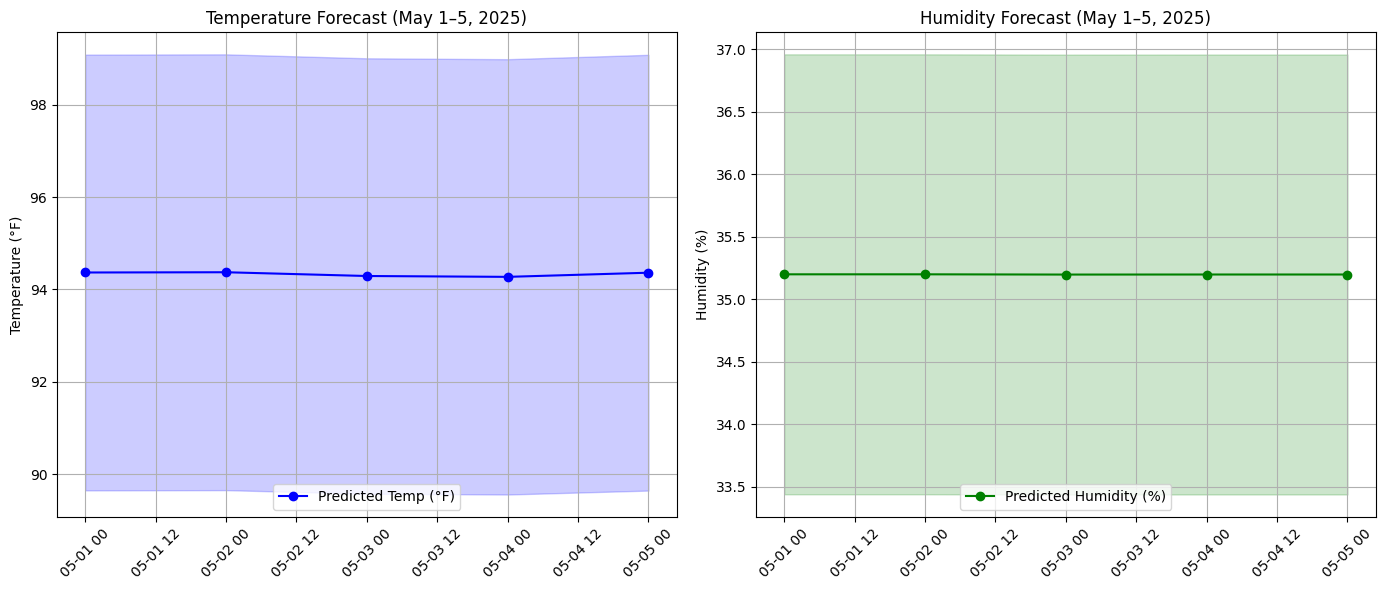

📅 Predicted Weather for May 1–5, 2025:


,Date,Predicted_Temperature,Temp_Range_Low,Temp_Range_High,Predicted_Humidity,Humidity_Range_Low,Humidity_Range_High
0,2025-05-01,94.3680,89.649600,99.086400,35.1980,33.438100,36.957900
1,2025-05-02,94.3735,89.654825,99.092175,35.1980,33.438100,36.957900
2,2025-05-03,94.2920,89.577400,99.006600,35.1960,33.436200,36.955800
3,2025-05-04,94.2735,89.559825,98.987175,35.1965,33.436675,36.956325
4,2025-05-05,94.3635,89.645325,99.081675,35.1965,33.436675,36.956325


In [ ]:
#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Upload your Excel file
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))

#  Load dataset
df = pd.read_excel(file_name)

#  Preprocessing
df.columns = [
    "Date", "Temp Max (F)", "Temp Avg (F)", "Temp Min (F)",
    "Dew Point Max (F)", "Dew Point Avg (F)", "Dew Point Min (F)",
    "Humidity Max (%)", "Humidity Avg (%)", "Humidity Min (%)",
    "Wind Speed Max (mph)", "Wind Speed Avg (mph)", "Wind Speed Min (mph)",
    "Pressure Max (in)", "Pressure Avg (in)", "Pressure Min (in)",
    "Precipitation Total (in)"
]
df["Date"] = pd.to_datetime(df["Date"])
df.interpolate(method='linear', inplace=True)

#  Feature Engineering
df["Month"] = df["Date"].dt.month
df["DayOfYear"] = df["Date"].dt.dayofyear
df["Season_Numeric"] = df["Month"].apply(lambda x: 0 if x in [12,1,2] else 1 if x in [3,4,5] else 2 if x in [6,7,8] else 3)

features = [
    "Dew Point Avg (F)", "Humidity Avg (%)", "Wind Speed Avg (mph)",
    "Pressure Avg (in)", "Precipitation Total (in)", "Month", "DayOfYear", "Season_Numeric"
]
target_temp = "Temp Avg (F)"
target_humidity = "Humidity Avg (%)"

X = df[features]
y_temp = df[target_temp]
y_humidity = df[target_humidity]

# 📚 Split data
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)
_, _, y_train_humidity, y_test_humidity = train_test_split(X, y_humidity, test_size=0.2, random_state=42)

#  Train models
best_temp_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_temp_model.fit(X_train, y_train_temp)

best_humidity_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
best_humidity_model.fit(X_train, y_train_humidity)

# Prediction function
def predict_future_weather(input_data, temp_model, humidity_model):
    temp_pred = temp_model.predict(input_data)
    hum_pred = humidity_model.predict(input_data)

    return pd.DataFrame({
        "Predicted_Temperature": temp_pred,
        "Temp_Range_Low": temp_pred * 0.95,
        "Temp_Range_High": temp_pred * 1.05,
        "Predicted_Humidity": hum_pred,
        "Humidity_Range_Low": hum_pred * 0.95,
        "Humidity_Range_High": hum_pred * 1.05
    })

#  Predict May 1–5, 2025
def predict_may_2025(df, temp_model, humidity_model):
    may_dates = [datetime(2025, 5, i) for i in range(1, 6)]
    recent = df.tail(7)
    avg_inputs = {
        "Dew Point Avg (F)": recent["Dew Point Avg (F)"].mean(),
        "Humidity Avg (%)": recent["Humidity Avg (%)"].mean(),
        "Wind Speed Avg (mph)": recent["Wind Speed Avg (mph)"].mean(),
        "Pressure Avg (in)": recent["Pressure Avg (in)"].mean(),
        "Precipitation Total (in)": recent["Precipitation Total (in)"].mean()
    }

    rows = []
    for date in may_dates:
        month = date.month
        day_of_year = date.timetuple().tm_yday
        season = 1  # Spring

        row = {
            **avg_inputs,
            "Month": month,
            "DayOfYear": day_of_year,
            "Season_Numeric": season
        }
        rows.append(row)

    input_df = pd.DataFrame(rows)
    prediction_df = predict_future_weather(input_df, temp_model, humidity_model)
    prediction_df["Date"] = may_dates

    #  Plotting
    plt.figure(figsize=(14, 6))

    # Temperature
    plt.subplot(1, 2, 1)
    plt.plot(prediction_df["Date"], prediction_df["Predicted_Temperature"], label="Predicted Temp (°F)", color="blue", marker="o")
    plt.fill_between(prediction_df["Date"], prediction_df["Temp_Range_Low"], prediction_df["Temp_Range_High"], color="blue", alpha=0.2)
    plt.title("Temperature Forecast (May 1–5, 2025)")
    plt.ylabel("Temperature (°F)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

    # Humidity
    plt.subplot(1, 2, 2)
    plt.plot(prediction_df["Date"], prediction_df["Predicted_Humidity"], label="Predicted Humidity (%)", color="green", marker="o")
    plt.fill_between(prediction_df["Date"], prediction_df["Humidity_Range_Low"], prediction_df["Humidity_Range_High"], color="green", alpha=0.2)
    plt.title("Humidity Forecast (May 1–5, 2025)")
    plt.ylabel("Humidity (%)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 📋 Show table
    print("📅 Predicted Weather for May 1–5, 2025:")
    return prediction_df[["Date", "Predicted_Temperature", "Temp_Range_Low", "Temp_Range_High",
                          "Predicted_Humidity", "Humidity_Range_Low", "Humidity_Range_High"]]

#  RUN prediction
predict_may_2025(df, best_temp_model, best_humidity_model)
